# SHAP feature selection #
## Code to select feature with combination of LightGBM and SHAP ##

## Parameters cell ##

Parameters are overiddent by papermill when run inside DVC stages



In [1]:
n_folds = 5 # this sets global setting of which how many bootstraps to use
n_hold_out = 0#1
repeats = 10
importance_type = "split"

life_history = ["lifespan", "mass_kg", "mtGC", "metabolic_rate", "temperature", "gestation_days"]
debug_local = True #to use local version

In [2]:
from pathlib import Path
import sys
import inspect

#lgb_params["importance_type"] = importance_type

local = (Path("..") / "yspecies").resolve()
if debug_local and local.exists():
  sys.path.insert(0, Path("..").as_posix())
  #sys.path.insert(0, local.as_posix())
  print("extending pathes with local yspecies")
  print(sys.path)
  %load_ext autoreload
  %autoreload 2

extending pathes with local yspecies
['..', '/data/sources/yspecies/notebooks', '/opt/miniconda3/envs/yspecies/lib/python38.zip', '/opt/miniconda3/envs/yspecies/lib/python3.8', '/opt/miniconda3/envs/yspecies/lib/python3.8/lib-dynload', '', '/opt/miniconda3/envs/yspecies/lib/python3.8/site-packages', '/opt/miniconda3/envs/yspecies/lib/python3.8/site-packages/IPython/extensions', '/home/antonkulaga/.ipython']


In [3]:
from dataclasses import dataclass, replace
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from typing import *
from yspecies.dataset import *
from yspecies.utils import *
from yspecies.config import *
from yspecies.preprocess import FeatureSelection
from yspecies.partition import PartitionParameters
from yspecies.models import Metrics
from yspecies.explanations import FeatureSummary

In [5]:
import optuna
from optuna import Study, Trial
from optuna import multi_objective
from optuna.multi_objective import trial
from optuna.multi_objective.study import MultiObjectiveStudy
from yspecies.tuning import MultiObjectiveResults

In [6]:
#settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import pprint
pp = pprint.PrettyPrinter(indent=4)

#charts settings
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib auto
plt.ioff()
set_matplotlib_formats('svg')

Using matplotlib backend: TkAgg


### Loading data ###
Let's load data from species/genes/expressions selected by select_samples.py notebook

In [7]:
from pathlib import Path
locations: Locations = Locations("./") if Path("./data").exists() else Locations("../")

## Setting up Features to select ##

In [8]:
default_selection = FeatureSelection(
    samples = ["tissue","species"], #samples metadata to include
    species =  [], #species metadata other then Y label to include
    exclude_from_training = ["species"],  #exclude some fields from LightGBM training
    to_predict = "lifespan", #column to predict
    categorical = ["tissue"],
    select_by = "shap",
    importance_type =  importance_type,
    feature_perturbation = "tree_path_dependent"
)
default_selection

FeatureSelection(samples=['tissue', 'species'], species=[], genes=None, to_predict='lifespan', categorical=['tissue'], exclude_from_training=['species'], genes_meta=None, select_by='shap', importance_type='split', feature_perturbation='tree_path_dependent', not_validated_species=[])

In [9]:
loader = DataLoader(locations, default_selection)
selections = loader.load_life_history()
selections["lifespan"][0]

<table border='2'><caption>lifespan<caption><tr><th>expressions</th><th>genes</th><th>species</th><th>samples</th><th>Genes Metadata</th><th>Species Metadata</th></tr><tr><td>(408, 12323)</td><td>(12323, 37)</td><td>38</td><td>408</td><td>(12323, 2)</td><td>(38, 18)</td></tr></table>

## Setting up SHAP selection pipeline ##

In [10]:
from yspecies.helpers import PipelineFactory
factory = PipelineFactory(locations,repeats, n_folds, n_hold_out)


In [11]:
pipelines = {trait:factory.make_repeated_shap_pipeline(trait) for trait in life_history}
#pipelines = {trait:factory.make_shap_pipeline(trait) for trait in life_history}

#make_partitioning_shap_pipeline
pipelines.keys()

loading (if exists) study from sqlite:////data/sources/yspecies/notebooks/../data/interim/optimization/lifespan.sqlite


create_study is experimental (supported from v1.4.0). The interface can change in the future.
NSGAIIMultiObjectiveSampler is experimental (supported from v1.5.0). The interface can change in the future.
RandomMultiObjectiveSampler is experimental (supported from v1.4.0). The interface can change in the future.
[I 2020-10-10 02:19:40,528] Using an existing study with name 'lifespan_r2_huber_kendall' instead of creating a new one.
MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.


loading (if exists) study from sqlite:////data/sources/yspecies/notebooks/../data/interim/optimization/mass_kg.sqlite


[I 2020-10-10 02:19:42,118] Using an existing study with name 'mass_kg_r2_huber_kendall' instead of creating a new one.


loading (if exists) study from sqlite:////data/sources/yspecies/notebooks/../data/interim/optimization/mtGC.sqlite


[I 2020-10-10 02:19:42,334] Using an existing study with name 'mtGC_r2_huber_kendall' instead of creating a new one.


loading (if exists) study from sqlite:////data/sources/yspecies/notebooks/../data/interim/optimization/metabolic_rate.sqlite


[I 2020-10-10 02:19:43,631] Using an existing study with name 'metabolic_rate_r2_huber_kendall' instead of creating a new one.


loading (if exists) study from sqlite:////data/sources/yspecies/notebooks/../data/interim/optimization/temperature.sqlite


[I 2020-10-10 02:19:43,794] Using an existing study with name 'temperature_r2_huber_kendall' instead of creating a new one.


FALLING BACK TO DEFAULT PARAMETERS
loading (if exists) study from sqlite:////data/sources/yspecies/notebooks/../data/interim/optimization/gestation_days.sqlite


[I 2020-10-10 02:19:43,815] Using an existing study with name 'gestation_days_r2_huber_kendall' instead of creating a new one.


dict_keys(['lifespan', 'mass_kg', 'mtGC', 'metabolic_rate', 'temperature', 'gestation_days'])

# First stage selection (shap ) #

In [12]:
stage_one = {}

In [13]:
def run_stage_one(trait: str):
    result = pipelines[trait].fit_transform(selections[trait])
    stage_one[trait] = result #ugly mutation of stage_one dicionary
    return result

## Lifespan ##

In [14]:
stage_one_lifespan = run_stage_one("lifespan")
stage_one_lifespan.selected

2020-10-10 02:19:44.908 | INFO     | yspecies.selection:fit:153 - ===== fitting models with seed 0 =====
2020-10-10 02:19:44.908 | INFO     | yspecies.selection:fit:154 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10}
2020-10-10 02:19:44.941 | INFO     | yspecies.selection:fit:157 - SEED: 0 | FOLD: 0 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Pan_paniscus']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[88]	valid_0's l1: 7.19976	valid_0's l2: 145.538	valid_0's huber: 6.13569


2020-10-10 02:19:47.058 | INFO     | yspecies.selection:fit:157 - SEED: 0 | FOLD: 1 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Capra_hircus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[153]	valid_0's l1: 3.72065	valid_0's l2: 45.1259	valid_0's huber: 3.01525


2020-10-10 02:19:49.808 | INFO     | yspecies.selection:fit:157 - SEED: 0 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Otolemur_garnettii']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[138]	valid_0's l1: 3.03845	valid_0's l2: 32.7294	valid_0's huber: 2.40662


2020-10-10 02:19:52.489 | INFO     | yspecies.selection:fit:157 - SEED: 0 | FOLD: 3 | VALIDATION_SPECIES: ['Macaca_nemestrina', 'Microcebus_murinus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[183]	valid_0's l1: 3.02283	valid_0's l2: 33.0322	valid_0's huber: 2.3831


2020-10-10 02:19:56.277 | INFO     | yspecies.selection:fit:157 - SEED: 0 | FOLD: 4 | VALIDATION_SPECIES: ['Felis_catus', 'Pan_troglodytes']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[106]	valid_0's l1: 3.17398	valid_0's l2: 29.6323	valid_0's huber: 2.51577


2020-10-10 02:20:03.201 | INFO     | yspecies.explanations:transform:566 - Metrics: 
Metrics(R2=0.9246526388668274, MAE=4.031133990541529, MSE=57.21158292663573, huber=3.2906634228868064)
2020-10-10 02:20:03.241 | INFO     | yspecies.selection:fit:153 - ===== fitting models with seed 1 =====
2020-10-10 02:20:03.242 | INFO     | yspecies.selection:fit:154 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 0}
2020-10-10 02:20:03.273 | INFO     | yspecies.selection:fit:157 - SEED: 1 | FOLD: 0 | VALIDATION_SPECIES: ['Felis_catus', 'Ursus_americanus']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[95]	valid_0's l1: 3.68333	valid_0's l2: 33.9969	valid_0's huber: 2.95567


2020-10-10 02:20:05.508 | INFO     | yspecies.selection:fit:157 - SEED: 1 | FOLD: 1 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Vombatus_ursinus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[87]	valid_0's l1: 4.46434	valid_0's l2: 63.9619	valid_0's huber: 3.69998


2020-10-10 02:20:07.525 | INFO     | yspecies.selection:fit:157 - SEED: 1 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Rhinopithecus_bieti']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[201]	valid_0's l1: 2.6059	valid_0's l2: 20.965	valid_0's huber: 2.0132


2020-10-10 02:20:13.251 | INFO     | yspecies.selection:fit:157 - SEED: 1 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Ovis_aries']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[201]	valid_0's l1: 4.43317	valid_0's l2: 73.381	valid_0's huber: 3.66424


2020-10-10 02:20:16.724 | INFO     | yspecies.selection:fit:157 - SEED: 1 | FOLD: 4 | VALIDATION_SPECIES: ['Pan_troglodytes', 'Ailuropoda_melanoleuca']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[214]	valid_0's l1: 3.06978	valid_0's l2: 36.2584	valid_0's huber: 2.44288


2020-10-10 02:20:24.916 | INFO     | yspecies.explanations:transform:566 - Metrics: 
Metrics(R2=0.9356085299969878, MAE=3.6513047981189173, MSE=45.71263599516901, huber=2.9496214407484724)
2020-10-10 02:20:24.953 | INFO     | yspecies.selection:fit:153 - ===== fitting models with seed 2 =====
2020-10-10 02:20:24.954 | INFO     | yspecies.selection:fit:154 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 1}
2020-10-10 02:20:24.980 | INFO     | yspecies.selection:fit:157 - SEED: 2 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ursus_americanus']
Found `early_stopping_round` in params. Will use it instead of 

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[174]	valid_0's l1: 3.07981	valid_0's l2: 38.3278	valid_0's huber: 2.43704


2020-10-10 02:20:28.125 | INFO     | yspecies.selection:fit:157 - SEED: 2 | FOLD: 1 | VALIDATION_SPECIES: ['Aotus_nancymaae', 'Phascolarctos_cinereus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[129]	valid_0's l1: 3.61557	valid_0's l2: 31.4308	valid_0's huber: 2.9186


2020-10-10 02:20:30.855 | INFO     | yspecies.selection:fit:157 - SEED: 2 | FOLD: 2 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Ailuropoda_melanoleuca']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[125]	valid_0's l1: 3.63086	valid_0's l2: 55.1932	valid_0's huber: 2.92872


2020-10-10 02:20:33.518 | INFO     | yspecies.selection:fit:157 - SEED: 2 | FOLD: 3 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Monodelphis_domestica']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 7.78715	valid_0's l2: 121.838	valid_0's huber: 6.63997
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 7.78715	valid_0's l2: 121.838	valid_0's huber: 6.63997


2020-10-10 02:20:36.804 | INFO     | yspecies.selection:fit:157 - SEED: 2 | FOLD: 4 | VALIDATION_SPECIES: ['Bos_taurus', 'Tupaia_belangeri']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[71]	valid_0's l1: 3.47087	valid_0's l2: 40.8103	valid_0's huber: 2.76301


2020-10-10 02:20:42.906 | INFO     | yspecies.explanations:transform:566 - Metrics: 
Metrics(R2=0.9029740041646577, MAE=4.316850548616003, MSE=57.51995149570786, huber=3.5361747291347)
2020-10-10 02:20:42.946 | INFO     | yspecies.selection:fit:153 - ===== fitting models with seed 3 =====
2020-10-10 02:20:42.946 | INFO     | yspecies.selection:fit:154 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 2}
2020-10-10 02:20:42.975 | INFO     | yspecies.selection:fit:157 - SEED: 3 | FOLD: 0 | VALIDATION_SPECIES: ['Microcebus_murinus', 'Pan_paniscus']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[177]	valid_0's l1: 2.87234	valid_0's l2: 27.9791	valid_0's huber: 2.24004


2020-10-10 02:20:46.061 | INFO     | yspecies.selection:fit:157 - SEED: 3 | FOLD: 1 | VALIDATION_SPECIES: ['Ursus_americanus', 'Gorilla_gorilla']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[140]	valid_0's l1: 6.46112	valid_0's l2: 94.6238	valid_0's huber: 5.45335


2020-10-10 02:20:48.923 | INFO     | yspecies.selection:fit:157 - SEED: 3 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Capra_hircus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[139]	valid_0's l1: 3.31768	valid_0's l2: 43.2744	valid_0's huber: 2.65811


2020-10-10 02:20:51.879 | INFO     | yspecies.selection:fit:157 - SEED: 3 | FOLD: 3 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Mus_musculus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[151]	valid_0's l1: 2.86569	valid_0's l2: 25.4216	valid_0's huber: 2.24454


2020-10-10 02:20:54.779 | INFO     | yspecies.selection:fit:157 - SEED: 3 | FOLD: 4 | VALIDATION_SPECIES: ['Suricata_suricatta', 'Meriones_unguiculatus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[129]	valid_0's l1: 2.99004	valid_0's l2: 29.0231	valid_0's huber: 2.3582


2020-10-10 02:21:02.931 | INFO     | yspecies.explanations:transform:566 - Metrics: 
Metrics(R2=0.9392830808788654, MAE=3.7013724664871033, MSE=44.064401270870135, huber=2.988888414503028)
2020-10-10 02:21:02.988 | INFO     | yspecies.selection:fit:153 - ===== fitting models with seed 4 =====
2020-10-10 02:21:02.989 | INFO     | yspecies.selection:fit:154 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 3}
2020-10-10 02:21:03.023 | INFO     | yspecies.selection:fit:157 - SEED: 4 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Pan_troglodytes']
Found `early_stopping_round` in params. Will use it instead of a

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[167]	valid_0's l1: 4.45369	valid_0's l2: 84.0444	valid_0's huber: 3.6718


2020-10-10 02:21:06.122 | INFO     | yspecies.selection:fit:157 - SEED: 4 | FOLD: 1 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ursus_americanus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[136]	valid_0's l1: 3.01683	valid_0's l2: 23.4436	valid_0's huber: 2.37886


2020-10-10 02:21:10.932 | INFO     | yspecies.selection:fit:157 - SEED: 4 | FOLD: 2 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Cavia_aperea']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[59]	valid_0's l1: 5.59421	valid_0's l2: 79.6306	valid_0's huber: 4.69236


2020-10-10 02:21:12.989 | INFO     | yspecies.selection:fit:157 - SEED: 4 | FOLD: 3 | VALIDATION_SPECIES: ['Pan_paniscus', 'Gorilla_gorilla']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[138]	valid_0's l1: 6.75044	valid_0's l2: 145.772	valid_0's huber: 5.73607


2020-10-10 02:21:15.619 | INFO     | yspecies.selection:fit:157 - SEED: 4 | FOLD: 4 | VALIDATION_SPECIES: ['Bos_taurus', 'Equus_caballus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[169]	valid_0's l1: 2.43093	valid_0's l2: 24.6421	valid_0's huber: 1.88982


2020-10-10 02:21:22.219 | INFO     | yspecies.explanations:transform:566 - Metrics: 
Metrics(R2=0.9016911897198568, MAE=4.449222583959903, MSE=71.50665079342278, huber=3.6653058158256813)
2020-10-10 02:21:22.261 | INFO     | yspecies.selection:fit:153 - ===== fitting models with seed 5 =====
2020-10-10 02:21:22.262 | INFO     | yspecies.selection:fit:154 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 4}
2020-10-10 02:21:22.292 | INFO     | yspecies.selection:fit:157 - SEED: 5 | FOLD: 0 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Canis_lupus_familiaris']
Found `early_stopping_round` in params. Will use it instead of 

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[69]	valid_0's l1: 2.87253	valid_0's l2: 22.0944	valid_0's huber: 2.23091


2020-10-10 02:21:24.428 | INFO     | yspecies.selection:fit:157 - SEED: 5 | FOLD: 1 | VALIDATION_SPECIES: ['Ovis_aries', 'Heterocephalus_glaber']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[113]	valid_0's l1: 3.57163	valid_0's l2: 42.1437	valid_0's huber: 2.86626


2020-10-10 02:21:26.992 | INFO     | yspecies.selection:fit:157 - SEED: 5 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Oryctolagus_cuniculus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[109]	valid_0's l1: 6.46174	valid_0's l2: 144.746	valid_0's huber: 5.46764


2020-10-10 02:21:29.431 | INFO     | yspecies.selection:fit:157 - SEED: 5 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_aperea', 'Ailuropoda_melanoleuca']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[170]	valid_0's l1: 4.01752	valid_0's l2: 77.9956	valid_0's huber: 3.29112


2020-10-10 02:21:32.451 | INFO     | yspecies.selection:fit:157 - SEED: 5 | FOLD: 4 | VALIDATION_SPECIES: ['Felis_catus', 'Rhinopithecus_bieti']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[88]	valid_0's l1: 2.84254	valid_0's l2: 31.2986	valid_0's huber: 2.2184


2020-10-10 02:21:38.818 | INFO     | yspecies.explanations:transform:566 - Metrics: 
Metrics(R2=0.911722027988383, MAE=3.953192377108499, MSE=63.65574284997937, huber=3.211274673171819)
2020-10-10 02:21:38.855 | INFO     | yspecies.selection:fit:153 - ===== fitting models with seed 6 =====
2020-10-10 02:21:38.856 | INFO     | yspecies.selection:fit:154 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 5}
2020-10-10 02:21:38.883 | INFO     | yspecies.selection:fit:157 - SEED: 6 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Heterocephalus_glaber']
Found `early_stopping_round` in params. Will use it ins

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[94]	valid_0's l1: 3.66302	valid_0's l2: 37.6046	valid_0's huber: 2.95223


2020-10-10 02:21:41.229 | INFO     | yspecies.selection:fit:157 - SEED: 6 | FOLD: 1 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Suricata_suricatta']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[163]	valid_0's l1: 3.10956	valid_0's l2: 41.3982	valid_0's huber: 2.47132


2020-10-10 02:21:44.307 | INFO     | yspecies.selection:fit:157 - SEED: 6 | FOLD: 2 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ovis_aries']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[115]	valid_0's l1: 3.44484	valid_0's l2: 47.9188	valid_0's huber: 2.769


2020-10-10 02:21:47.109 | INFO     | yspecies.selection:fit:157 - SEED: 6 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Pan_troglodytes']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[122]	valid_0's l1: 3.83902	valid_0's l2: 65.9981	valid_0's huber: 3.11685


2020-10-10 02:21:49.979 | INFO     | yspecies.selection:fit:157 - SEED: 6 | FOLD: 4 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Sus_scrofa']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[103]	valid_0's l1: 2.91941	valid_0's l2: 32.3053	valid_0's huber: 2.30184


2020-10-10 02:21:57.801 | INFO     | yspecies.explanations:transform:566 - Metrics: 
Metrics(R2=0.9358267913202096, MAE=3.395169660301799, MSE=45.04499424360979, huber=2.718061409608745)
2020-10-10 02:21:57.847 | INFO     | yspecies.selection:fit:153 - ===== fitting models with seed 7 =====
2020-10-10 02:21:57.848 | INFO     | yspecies.selection:fit:154 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 6}
2020-10-10 02:21:57.877 | INFO     | yspecies.selection:fit:157 - SEED: 7 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Cavia_porcellus']
Found `early_stopping_round` in params. Will use it instead of argument

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[123]	valid_0's l1: 3.75138	valid_0's l2: 33.1592	valid_0's huber: 3.02897


2020-10-10 02:22:00.739 | INFO     | yspecies.selection:fit:157 - SEED: 7 | FOLD: 1 | VALIDATION_SPECIES: ['Pan_paniscus', 'Capra_hircus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[146]	valid_0's l1: 3.26387	valid_0's l2: 44.7135	valid_0's huber: 2.61378


2020-10-10 02:22:03.770 | INFO     | yspecies.selection:fit:157 - SEED: 7 | FOLD: 2 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ictidomys_tridecemlineatus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[101]	valid_0's l1: 3.79785	valid_0's l2: 41.7174	valid_0's huber: 3.09612


2020-10-10 02:22:06.436 | INFO     | yspecies.selection:fit:157 - SEED: 7 | FOLD: 3 | VALIDATION_SPECIES: ['Canis_lupus_familiaris', 'Ursus_americanus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[151]	valid_0's l1: 2.94446	valid_0's l2: 43.579	valid_0's huber: 2.3427


2020-10-10 02:22:09.643 | INFO     | yspecies.selection:fit:157 - SEED: 7 | FOLD: 4 | VALIDATION_SPECIES: ['Tupaia_belangeri', 'Ailuropoda_melanoleuca']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[76]	valid_0's l1: 2.9984	valid_0's l2: 33.7427	valid_0's huber: 2.36503


2020-10-10 02:22:16.434 | INFO     | yspecies.explanations:transform:566 - Metrics: 
Metrics(R2=0.9444864457797776, MAE=3.351192100760047, MSE=39.382353600041, huber=2.6855729362485636)
2020-10-10 02:22:16.479 | INFO     | yspecies.selection:fit:153 - ===== fitting models with seed 8 =====
2020-10-10 02:22:16.479 | INFO     | yspecies.selection:fit:154 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 7}
2020-10-10 02:22:16.509 | INFO     | yspecies.selection:fit:157 - SEED: 8 | FOLD: 0 | VALIDATION_SPECIES: ['Pan_paniscus', 'Suricata_suricatta']
Found `early_stopping_round` in params. Will use it instead of argument

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[152]	valid_0's l1: 2.5804	valid_0's l2: 32.0191	valid_0's huber: 2.00311


2020-10-10 02:22:19.314 | INFO     | yspecies.selection:fit:157 - SEED: 8 | FOLD: 1 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Tupaia_belangeri']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[94]	valid_0's l1: 3.57998	valid_0's l2: 35.9089	valid_0's huber: 2.88969


2020-10-10 02:22:21.568 | INFO     | yspecies.selection:fit:157 - SEED: 8 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Capra_hircus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[190]	valid_0's l1: 3.72318	valid_0's l2: 44.2886	valid_0's huber: 3.01608


2020-10-10 02:22:24.754 | INFO     | yspecies.selection:fit:157 - SEED: 8 | FOLD: 3 | VALIDATION_SPECIES: ['Bos_taurus', 'Rhinolophus_ferrumequinum']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[160]	valid_0's l1: 2.81913	valid_0's l2: 52.3629	valid_0's huber: 2.23579


2020-10-10 02:22:28.211 | INFO     | yspecies.selection:fit:157 - SEED: 8 | FOLD: 4 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Sus_scrofa']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[150]	valid_0's l1: 3.14176	valid_0's l2: 32.7678	valid_0's huber: 2.51718


2020-10-10 02:22:36.319 | INFO     | yspecies.explanations:transform:566 - Metrics: 
Metrics(R2=0.9431361513678478, MAE=3.168891944863792, MSE=39.46947026133172, huber=2.5290842319876012)
2020-10-10 02:22:36.365 | INFO     | yspecies.selection:fit:153 - ===== fitting models with seed 9 =====
2020-10-10 02:22:36.366 | INFO     | yspecies.selection:fit:154 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 8}
2020-10-10 02:22:36.397 | INFO     | yspecies.selection:fit:157 - SEED: 9 | FOLD: 0 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Aotus_nancymaae']
Found `early_stopping_round` in params. Will use it instea

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[110]	valid_0's l1: 3.9115	valid_0's l2: 43.3614	valid_0's huber: 3.18864


2020-10-10 02:22:39.032 | INFO     | yspecies.selection:fit:157 - SEED: 9 | FOLD: 1 | VALIDATION_SPECIES: ['Pan_troglodytes', 'Oryctolagus_cuniculus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[96]	valid_0's l1: 5.6937	valid_0's l2: 82.8679	valid_0's huber: 4.79542


2020-10-10 02:22:41.460 | INFO     | yspecies.selection:fit:157 - SEED: 9 | FOLD: 2 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Meriones_unguiculatus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[85]	valid_0's l1: 5.29656	valid_0's l2: 62.6372	valid_0's huber: 4.41323


2020-10-10 02:22:43.700 | INFO     | yspecies.selection:fit:157 - SEED: 9 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Microcebus_murinus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[101]	valid_0's l1: 5.81197	valid_0's l2: 109.359	valid_0's huber: 4.88991


2020-10-10 02:22:46.275 | INFO     | yspecies.selection:fit:157 - SEED: 9 | FOLD: 4 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Felis_catus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[155]	valid_0's l1: 2.95247	valid_0's l2: 26.1484	valid_0's huber: 2.34357


2020-10-10 02:22:53.395 | INFO     | yspecies.explanations:transform:566 - Metrics: 
Metrics(R2=0.909116294102083, MAE=4.733238624486459, MSE=64.87474281961457, huber=3.927041664017698)


symbol  repeats  mean_shap  mean_kendall_tau  shap_0  \
ENSG00000010219     DYRK4   10.000     10.220             0.325   9.200   
ENSG00000204498   NFKBIL1   10.000      7.580            -0.128   7.400   
ENSG00000167515  TRAPPC2L   10.000      6.480            -0.279   4.800   
ENSG00000170835       CEL   10.000      4.740             0.693   6.600   
ENSG00000105672      ETV2   10.000      4.040             0.713   4.600   
ENSG00000185880    TRIM69   10.000      3.420             0.097   3.600   
ENSG00000066923     STAG3    9.000      6.422             0.480   6.600   
ENSG00000132436    FIGNL1    9.000      3.422             0.570   3.400   
ENSG00000165501      LRR1    9.000      3.244             0.688   3.200   
ENSG00000013288    MAN2B2    9.000      2.289            -0.325   2.200   
ENSG00000188747     NOXA1    9.000      2.111             0.689     nan   
ENSG00000171121    KCNMB3    8.000      3.375             0.610   3.400   
ENSG00000165555   NOXRED1    8.000      3.250             0.775   3.800   
ENSG00000023191      RNH1    7.000      3.143            -0.424     nan   
ENSG00000142002      DPP9    7.000      2.371            -0.716     nan   
ENSG00000172531    PPP1CA    6.000      3.400            -0.761   3.600   
ENSG00000106554    CHCHD3    6.000      3.233            -0.387     nan   
ENSG00000137411     VARS2    6.000      3.100            -0.255   2.200   
ENSG00000137343     ATAT1    6.000      2.867            -0.457   3.200   
ENSG00000066926      FECH    6.000      2.733            -0.429   2.800   
ENSG00000157343    ARMC12    6.000      2.367             0.596   2.600   
ENSG00000164879       CA3    5.000      2.040            -0.454   2.600   
ENSG00000102265     TIMP1    5.000      1.760             0.576     nan   
ENSG00000204231      RXRB    4.000      4.750            -0.152     nan   
ENSG00000092529     CAPN3    4.000      3.250             0.414     nan   
ENSG00000160948     VPS28    4.000      2.500            -0.320   2.600   
ENSG00000164362      TERT    4.000      2.500            -0.466   3.000   
ENSG00000144451    SPAG16    4.000      2.400             0.515   2.200   
ENSG00000136436  CALCOCO2    4.000      2.100             0.722     nan   
ENSG00000134489      HRH4    4.000      1.850             0.641     nan   
ENSG00000006282   SPATA20    3.000      2.133             0.608     nan   
ENSG00000120675   DNAJC15    3.000      2.067            -0.649   2.000   
ENSG00000129187      DCTD    3.000      1.600             0.632     nan   
ENSG00000108384    RAD51C    2.000      2.600             0.523     nan   
ENSG00000127952    STYXL1    2.000      2.500             0.549   2.800   
ENSG00000140398     NEIL1    2.000      2.000             0.661     nan   
ENSG00000182612   TSPAN10    2.000      1.900             0.469   1.800   
ENSG00000152705  CATSPER3    2.000      1.700             0.717     nan   
ENSG00000203710       CR1    2.000      1.500            -0.567     nan   
ENSG00000242715   CCDC169    1.000      2.600             0.674     nan   
ENSG00000149089      APIP    1.000      2.600             0.587     nan   
ENSG00000184983    NDUFA6    1.000      2.600            -0.698     nan   
ENSG00000101182     PSMA7    1.000      2.400            -0.382     nan   
ENSG00000122033     MTIF3    1.000      2.200             0.508   2.200   
ENSG00000100764     PSMC1    1.000      2.000            -0.559     nan   
ENSG00000170892    TSEN34    1.000      1.800            -0.413     nan   
ENSG00000198663   C6orf89    1.000      1.800            -0.686     nan   
ENSG00000142541    RPL13A    1.000      1.600            -0.211     nan   
ENSG00000100902     PSMA6    1.000      1.600            -0.305     nan   
ENSG00000122034     GTF3A    1.000      1.400             0.539     nan   
ENSG00000153157    SYCP2L    1.000      1.400             0.245     nan   
ENSG00000188322      SBK1    1.000      1.400            -0.529     nan   
ENSG00000165689     ENTR1    1.000      1.40

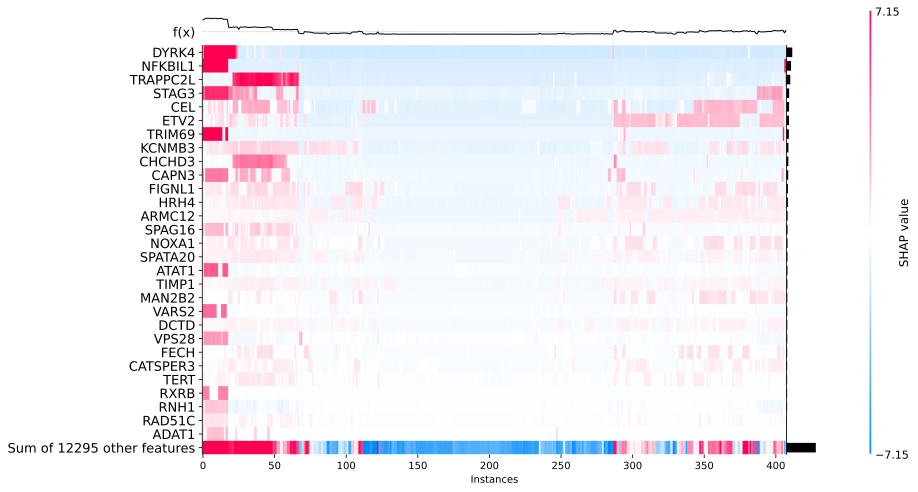

In [23]:
heatmap_stage_one_plot_path = locations.output.plots / "stage_one" / "heatmap_lifespan.svg"
stage_one_lifespan.plot_heatmap(True, max_display = 30, figsize = (14,8), sort_by_clust=True, save = heatmap_stage_one_plot_path)

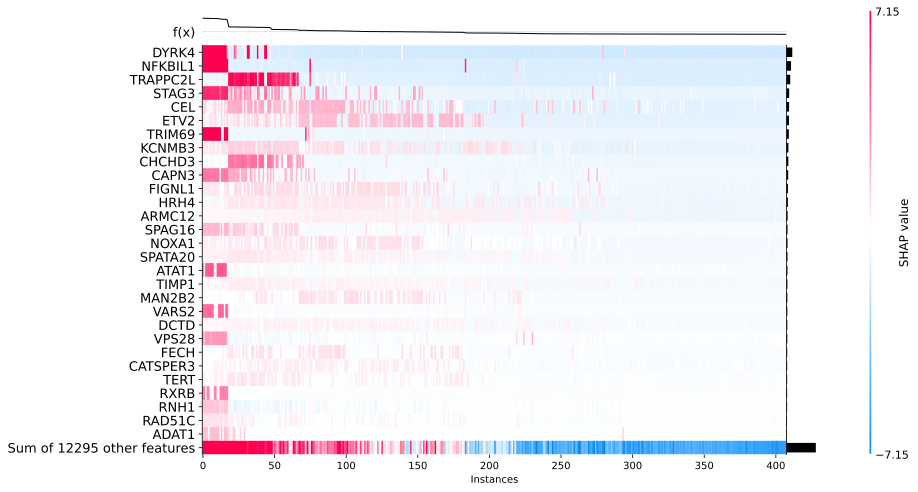

In [24]:
heatmap_uncl_stage_one_plot_path = locations.output.plots / "stage_one" / "heatmap_lifespan_unclustered.svg"
stage_one_lifespan.plot_heatmap(True, max_display = 30, figsize = (14,8), sort_by_clust=False, save = heatmap_uncl_stage_one_plot_path)

### saving partitions info  ###

In [16]:
stage_one_lifespan.write(locations.interim.stage_one / "partitions", "lifespan_stage_one")

PosixPath('../data/interim/stage_1/partitions')

### Mass_kg ###

In [17]:
stage_one_mass = run_stage_one("mass_kg")
stage_one_mass.selected

2020-10-10 02:23:52.943 | INFO     | yspecies.selection:fit:153 - ===== fitting models with seed 0 =====
2020-10-10 02:23:52.944 | INFO     | yspecies.selection:fit:154 - PARAMETERS:
{'bagging_fraction': 0.49885668399953875, 'boosting_type': 'dart', 'drop_rate': 0.2372958868935867, 'feature_fraction': 0.49141007534802034, 'lambda_l1': 0.656412473127467, 'lambda_l2': 1.9535470163293591, 'learning_rate': 0.08702343727058373, 'max_depth': 3, 'max_leaves': 21, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10}
2020-10-10 02:23:52.965 | INFO     | yspecies.selection:fit:157 - SEED: 0 | FOLD: 0 | VALIDATION_SPECIES: ['Monodelphis_domestica', 'Aotus_nancymaae']
Found `early_stopping_round` in params. Will use it instead of argument
Early stopping is not available in dart mode


[250]	valid_0's l1: 10.9715	valid_0's l2: 332.571	valid_0's huber: 9.50993


2020-10-10 02:23:57.721 | INFO     | yspecies.selection:fit:157 - SEED: 0 | FOLD: 1 | VALIDATION_SPECIES: ['Sus_scrofa', 'Oryctolagus_cuniculus']


[250]	valid_0's l1: 29.7375	valid_0's l2: 2258.84	valid_0's huber: 26.4168


2020-10-10 02:24:01.629 | INFO     | yspecies.selection:fit:157 - SEED: 0 | FOLD: 2 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Cavia_porcellus']


[250]	valid_0's l1: 12.7621	valid_0's l2: 374.396	valid_0's huber: 11.1286


2020-10-10 02:24:05.404 | INFO     | yspecies.selection:fit:157 - SEED: 0 | FOLD: 3 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Phascolarctos_cinereus']


[250]	valid_0's l1: 10.9439	valid_0's l2: 775.942	valid_0's huber: 9.48571


2020-10-10 02:24:09.558 | INFO     | yspecies.selection:fit:157 - SEED: 0 | FOLD: 4 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Suricata_suricatta']


[250]	valid_0's l1: 8.11425	valid_0's l2: 511.406	valid_0's huber: 7.01932


2020-10-10 02:24:15.525 | INFO     | yspecies.explanations:transform:566 - Metrics: 
Metrics(R2=0.7998223708997979, MAE=14.505852743291067, MSE=850.6303060021864, huber=12.71206783840921)
2020-10-10 02:24:15.553 | INFO     | yspecies.selection:fit:153 - ===== fitting models with seed 1 =====
2020-10-10 02:24:15.554 | INFO     | yspecies.selection:fit:154 - PARAMETERS:
{'bagging_fraction': 0.49885668399953875, 'boosting_type': 'dart', 'drop_rate': 0.2372958868935867, 'feature_fraction': 0.49141007534802034, 'lambda_l1': 0.656412473127467, 'lambda_l2': 1.9535470163293591, 'learning_rate': 0.08702343727058373, 'max_depth': 3, 'max_leaves': 21, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 0}
2020-10-10 02:24:15.577 | INFO     | yspecies.selection:fit:157 - SEED: 1 | FOLD: 0 | VALIDATION_SPECIES: ['Aotus_nancymaae', 'Mesocricetus_auratus']
Found `early_stopping_round` in params. Will use it instead of 

[250]	valid_0's l1: 6.60053	valid_0's l2: 213.566	valid_0's huber: 5.5862


2020-10-10 02:24:19.220 | INFO     | yspecies.selection:fit:157 - SEED: 1 | FOLD: 1 | VALIDATION_SPECIES: ['Monodelphis_domestica', 'Rattus_norvegicus']


[250]	valid_0's l1: 9.95402	valid_0's l2: 302.339	valid_0's huber: 8.58543


2020-10-10 02:24:22.320 | INFO     | yspecies.selection:fit:157 - SEED: 1 | FOLD: 2 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Sus_scrofa']


[250]	valid_0's l1: 30.2798	valid_0's l2: 2097.63	valid_0's huber: 26.8955


2020-10-10 02:24:26.088 | INFO     | yspecies.selection:fit:157 - SEED: 1 | FOLD: 3 | VALIDATION_SPECIES: ['Homo_sapiens', 'Cavia_porcellus']


[250]	valid_0's l1: 24.5026	valid_0's l2: 1422.41	valid_0's huber: 21.6771


2020-10-10 02:24:33.202 | INFO     | yspecies.selection:fit:157 - SEED: 1 | FOLD: 4 | VALIDATION_SPECIES: ['Meriones_unguiculatus', 'Suricata_suricatta']


[250]	valid_0's l1: 20.6584	valid_0's l2: 1048.04	valid_0's huber: 18.2273


2020-10-10 02:24:50.600 | INFO     | yspecies.explanations:transform:566 - Metrics: 
Metrics(R2=0.7437366567996347, MAE=18.399054702170407, MSE=1016.7955423169982, huber=16.194306163637314)
2020-10-10 02:24:50.638 | INFO     | yspecies.selection:fit:153 - ===== fitting models with seed 2 =====
2020-10-10 02:24:50.639 | INFO     | yspecies.selection:fit:154 - PARAMETERS:
{'bagging_fraction': 0.49885668399953875, 'boosting_type': 'dart', 'drop_rate': 0.2372958868935867, 'feature_fraction': 0.49141007534802034, 'lambda_l1': 0.656412473127467, 'lambda_l2': 1.9535470163293591, 'learning_rate': 0.08702343727058373, 'max_depth': 3, 'max_leaves': 21, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 1}
2020-10-10 02:24:50.658 | INFO     | yspecies.selection:fit:157 - SEED: 2 | FOLD: 0 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Meriones_unguiculatus']
Found `early_stopping_round` in params. Will use it instea

[250]	valid_0's l1: 6.91184	valid_0's l2: 176.272	valid_0's huber: 5.86597


2020-10-10 02:24:54.056 | INFO     | yspecies.selection:fit:157 - SEED: 2 | FOLD: 1 | VALIDATION_SPECIES: ['Suricata_suricatta', 'Mesocricetus_auratus']


[250]	valid_0's l1: 8.21443	valid_0's l2: 338.728	valid_0's huber: 7.08194


2020-10-10 02:24:57.875 | INFO     | yspecies.selection:fit:157 - SEED: 2 | FOLD: 2 | VALIDATION_SPECIES: ['Phascolarctos_cinereus', 'Cavia_porcellus']


[250]	valid_0's l1: 8.05211	valid_0's l2: 178.441	valid_0's huber: 6.89395


2020-10-10 02:25:01.589 | INFO     | yspecies.selection:fit:157 - SEED: 2 | FOLD: 3 | VALIDATION_SPECIES: ['Homo_sapiens', 'Aotus_nancymaae']


[250]	valid_0's l1: 34.1223	valid_0's l2: 2210.72	valid_0's huber: 30.3531


2020-10-10 02:25:08.452 | INFO     | yspecies.selection:fit:157 - SEED: 2 | FOLD: 4 | VALIDATION_SPECIES: ['Callithrix_jacchus', 'Otolemur_garnettii']


[250]	valid_0's l1: 7.88041	valid_0's l2: 205.466	valid_0's huber: 6.78057


2020-10-10 02:25:14.398 | INFO     | yspecies.explanations:transform:566 - Metrics: 
Metrics(R2=0.8303026028540769, MAE=13.036214196990912, MSE=621.9251345658884, huber=11.395107378231414)
2020-10-10 02:25:14.431 | INFO     | yspecies.selection:fit:153 - ===== fitting models with seed 3 =====
2020-10-10 02:25:14.431 | INFO     | yspecies.selection:fit:154 - PARAMETERS:
{'bagging_fraction': 0.49885668399953875, 'boosting_type': 'dart', 'drop_rate': 0.2372958868935867, 'feature_fraction': 0.49141007534802034, 'lambda_l1': 0.656412473127467, 'lambda_l2': 1.9535470163293591, 'learning_rate': 0.08702343727058373, 'max_depth': 3, 'max_leaves': 21, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 2}
2020-10-10 02:25:14.450 | INFO     | yspecies.selection:fit:157 - SEED: 3 | FOLD: 0 | VALIDATION_SPECIES: ['Callithrix_jacchus', 'Rattus_norvegicus']
Found `early_stopping_round` in params. Will use it instead of

[250]	valid_0's l1: 8.24669	valid_0's l2: 212.25	valid_0's huber: 7.04254


2020-10-10 02:25:17.445 | INFO     | yspecies.selection:fit:157 - SEED: 3 | FOLD: 1 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Oryctolagus_cuniculus']


[250]	valid_0's l1: 18.4178	valid_0's l2: 1047.91	valid_0's huber: 16.2602


2020-10-10 02:25:20.834 | INFO     | yspecies.selection:fit:157 - SEED: 3 | FOLD: 2 | VALIDATION_SPECIES: ['Sus_scrofa', 'Aotus_nancymaae']


[250]	valid_0's l1: 19.7022	valid_0's l2: 1149.05	valid_0's huber: 17.3981


2020-10-10 02:25:24.894 | INFO     | yspecies.selection:fit:157 - SEED: 3 | FOLD: 3 | VALIDATION_SPECIES: ['Meriones_unguiculatus', 'Mesocricetus_auratus']


[250]	valid_0's l1: 12.5941	valid_0's l2: 591.213	valid_0's huber: 10.9859


2020-10-10 02:25:28.059 | INFO     | yspecies.selection:fit:157 - SEED: 3 | FOLD: 4 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Suricata_suricatta']


[250]	valid_0's l1: 11.3286	valid_0's l2: 324.07	valid_0's huber: 9.82973


2020-10-10 02:25:34.319 | INFO     | yspecies.explanations:transform:566 - Metrics: 
Metrics(R2=0.8375715681987812, MAE=14.057864184714862, MSE=664.8983410080643, huber=12.303299914371275)
2020-10-10 02:25:34.359 | INFO     | yspecies.selection:fit:153 - ===== fitting models with seed 4 =====
2020-10-10 02:25:34.359 | INFO     | yspecies.selection:fit:154 - PARAMETERS:
{'bagging_fraction': 0.49885668399953875, 'boosting_type': 'dart', 'drop_rate': 0.2372958868935867, 'feature_fraction': 0.49141007534802034, 'lambda_l1': 0.656412473127467, 'lambda_l2': 1.9535470163293591, 'learning_rate': 0.08702343727058373, 'max_depth': 3, 'max_leaves': 21, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 3}
2020-10-10 02:25:34.378 | INFO     | yspecies.selection:fit:157 - SEED: 4 | FOLD: 0 | VALIDATION_SPECIES: ['Callithrix_jacchus', 'Heterocephalus_glaber']
Found `early_stopping_round` in params. Will use it instea

[250]	valid_0's l1: 15.1372	valid_0's l2: 444.758	valid_0's huber: 13.2384


2020-10-10 02:25:38.464 | INFO     | yspecies.selection:fit:157 - SEED: 4 | FOLD: 1 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Aotus_nancymaae']


[250]	valid_0's l1: 7.4358	valid_0's l2: 178.219	valid_0's huber: 6.33994


2020-10-10 02:25:42.980 | INFO     | yspecies.selection:fit:157 - SEED: 4 | FOLD: 2 | VALIDATION_SPECIES: ['Homo_sapiens', 'Rattus_norvegicus']


[250]	valid_0's l1: 15.568	valid_0's l2: 821.272	valid_0's huber: 13.6547


2020-10-10 02:25:49.176 | INFO     | yspecies.selection:fit:157 - SEED: 4 | FOLD: 3 | VALIDATION_SPECIES: ['Phascolarctos_cinereus', 'Ictidomys_tridecemlineatus']


[250]	valid_0's l1: 7.88776	valid_0's l2: 291.967	valid_0's huber: 6.74741


2020-10-10 02:25:53.174 | INFO     | yspecies.selection:fit:157 - SEED: 4 | FOLD: 4 | VALIDATION_SPECIES: ['Monodelphis_domestica', 'Meriones_unguiculatus']


[250]	valid_0's l1: 11.7718	valid_0's l2: 396.074	valid_0's huber: 10.2583


2020-10-10 02:25:58.702 | INFO     | yspecies.explanations:transform:566 - Metrics: 
Metrics(R2=0.8606311857545365, MAE=11.560105341845809, MSE=426.45794612956644, huber=10.047760395418496)
2020-10-10 02:25:58.746 | INFO     | yspecies.selection:fit:153 - ===== fitting models with seed 5 =====
2020-10-10 02:25:58.747 | INFO     | yspecies.selection:fit:154 - PARAMETERS:
{'bagging_fraction': 0.49885668399953875, 'boosting_type': 'dart', 'drop_rate': 0.2372958868935867, 'feature_fraction': 0.49141007534802034, 'lambda_l1': 0.656412473127467, 'lambda_l2': 1.9535470163293591, 'learning_rate': 0.08702343727058373, 'max_depth': 3, 'max_leaves': 21, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 4}
2020-10-10 02:25:58.767 | INFO     | yspecies.selection:fit:157 - SEED: 5 | FOLD: 0 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Heterocephalus_glaber']
Found `early_stopping_round` in params. Will use it in

[250]	valid_0's l1: 17.1416	valid_0's l2: 642.053	valid_0's huber: 15.0433


2020-10-10 02:26:02.956 | INFO     | yspecies.selection:fit:157 - SEED: 5 | FOLD: 1 | VALIDATION_SPECIES: ['Meriones_unguiculatus', 'Suricata_suricatta']


[250]	valid_0's l1: 13.2796	valid_0's l2: 405.574	valid_0's huber: 11.6019


2020-10-10 02:26:08.167 | INFO     | yspecies.selection:fit:157 - SEED: 5 | FOLD: 2 | VALIDATION_SPECIES: ['Sus_scrofa', 'Ictidomys_tridecemlineatus']


[250]	valid_0's l1: 15.5079	valid_0's l2: 537.54	valid_0's huber: 13.6111


2020-10-10 02:26:13.243 | INFO     | yspecies.selection:fit:157 - SEED: 5 | FOLD: 3 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Otolemur_garnettii']


[250]	valid_0's l1: 4.10204	valid_0's l2: 159.519	valid_0's huber: 3.33946


2020-10-10 02:26:17.350 | INFO     | yspecies.selection:fit:157 - SEED: 5 | FOLD: 4 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Mesocricetus_auratus']


[250]	valid_0's l1: 10.2841	valid_0's l2: 282.298	valid_0's huber: 8.91526


2020-10-10 02:26:23.710 | INFO     | yspecies.explanations:transform:566 - Metrics: 
Metrics(R2=0.8984468514338598, MAE=12.063029341164928, MSE=405.39699610786295, huber=10.502211673890372)
2020-10-10 02:26:23.755 | INFO     | yspecies.selection:fit:153 - ===== fitting models with seed 6 =====
2020-10-10 02:26:23.755 | INFO     | yspecies.selection:fit:154 - PARAMETERS:
{'bagging_fraction': 0.49885668399953875, 'boosting_type': 'dart', 'drop_rate': 0.2372958868935867, 'feature_fraction': 0.49141007534802034, 'lambda_l1': 0.656412473127467, 'lambda_l2': 1.9535470163293591, 'learning_rate': 0.08702343727058373, 'max_depth': 3, 'max_leaves': 21, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 5}
2020-10-10 02:26:23.774 | INFO     | yspecies.selection:fit:157 - SEED: 6 | FOLD: 0 | VALIDATION_SPECIES: ['Callithrix_jacchus', 'Ictidomys_tridecemlineatus']
Found `early_stopping_round` in params. Will use it 

[250]	valid_0's l1: 9.28334	valid_0's l2: 307.983	valid_0's huber: 8.02614


2020-10-10 02:26:27.687 | INFO     | yspecies.selection:fit:157 - SEED: 6 | FOLD: 1 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Otolemur_garnettii']


[250]	valid_0's l1: 16.7967	valid_0's l2: 1054.69	valid_0's huber: 14.7837


2020-10-10 02:26:31.652 | INFO     | yspecies.selection:fit:157 - SEED: 6 | FOLD: 2 | VALIDATION_SPECIES: ['Meriones_unguiculatus', 'Sus_scrofa']


[250]	valid_0's l1: 21.0091	valid_0's l2: 2037.87	valid_0's huber: 18.572


2020-10-10 02:26:35.075 | INFO     | yspecies.selection:fit:157 - SEED: 6 | FOLD: 3 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Homo_sapiens']


[250]	valid_0's l1: 25.1368	valid_0's l2: 1538.15	valid_0's huber: 22.2859


2020-10-10 02:26:38.764 | INFO     | yspecies.selection:fit:157 - SEED: 6 | FOLD: 4 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Monodelphis_domestica']


[250]	valid_0's l1: 10.3047	valid_0's l2: 320.755	valid_0's huber: 8.9327


2020-10-10 02:26:44.388 | INFO     | yspecies.explanations:transform:566 - Metrics: 
Metrics(R2=0.7159526197856538, MAE=16.506129157741704, MSE=1051.888431079698, huber=14.52011296194431)
2020-10-10 02:26:44.423 | INFO     | yspecies.selection:fit:153 - ===== fitting models with seed 7 =====
2020-10-10 02:26:44.423 | INFO     | yspecies.selection:fit:154 - PARAMETERS:
{'bagging_fraction': 0.49885668399953875, 'boosting_type': 'dart', 'drop_rate': 0.2372958868935867, 'feature_fraction': 0.49141007534802034, 'lambda_l1': 0.656412473127467, 'lambda_l2': 1.9535470163293591, 'learning_rate': 0.08702343727058373, 'max_depth': 3, 'max_leaves': 21, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 6}
2020-10-10 02:26:44.442 | INFO     | yspecies.selection:fit:157 - SEED: 7 | FOLD: 0 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ictidomys_tridecemlineatus']
Found `early_stopping_round` in params. Will use it in

[250]	valid_0's l1: 10.1493	valid_0's l2: 310.121	valid_0's huber: 8.75135


2020-10-10 02:26:48.302 | INFO     | yspecies.selection:fit:157 - SEED: 7 | FOLD: 1 | VALIDATION_SPECIES: ['Suricata_suricatta', 'Oryctolagus_cuniculus']


[250]	valid_0's l1: 30.7489	valid_0's l2: 1886.44	valid_0's huber: 27.2904


2020-10-10 02:26:52.024 | INFO     | yspecies.selection:fit:157 - SEED: 7 | FOLD: 2 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Monodelphis_domestica']


[250]	valid_0's l1: 9.47497	valid_0's l2: 299.192	valid_0's huber: 8.15754


2020-10-10 02:26:55.556 | INFO     | yspecies.selection:fit:157 - SEED: 7 | FOLD: 3 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Rattus_norvegicus']


[250]	valid_0's l1: 4.72887	valid_0's l2: 216.881	valid_0's huber: 3.89021


2020-10-10 02:27:02.675 | INFO     | yspecies.selection:fit:157 - SEED: 7 | FOLD: 4 | VALIDATION_SPECIES: ['Callithrix_jacchus', 'Sus_scrofa']


[250]	valid_0's l1: 36.1554	valid_0's l2: 2326.47	valid_0's huber: 32.1867


2020-10-10 02:27:08.973 | INFO     | yspecies.explanations:transform:566 - Metrics: 
Metrics(R2=0.789570919502982, MAE=18.251488656822367, MSE=1007.8209946311981, huber=16.055244691886404)
2020-10-10 02:27:09.008 | INFO     | yspecies.selection:fit:153 - ===== fitting models with seed 8 =====
2020-10-10 02:27:09.009 | INFO     | yspecies.selection:fit:154 - PARAMETERS:
{'bagging_fraction': 0.49885668399953875, 'boosting_type': 'dart', 'drop_rate': 0.2372958868935867, 'feature_fraction': 0.49141007534802034, 'lambda_l1': 0.656412473127467, 'lambda_l2': 1.9535470163293591, 'learning_rate': 0.08702343727058373, 'max_depth': 3, 'max_leaves': 21, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 7}
2020-10-10 02:27:09.032 | INFO     | yspecies.selection:fit:157 - SEED: 8 | FOLD: 0 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Otolemur_garnettii']
Found `early_stopping_round` in params. Will use it instea

[250]	valid_0's l1: 19.4383	valid_0's l2: 1159.92	valid_0's huber: 17.1807


2020-10-10 02:27:12.830 | INFO     | yspecies.selection:fit:157 - SEED: 8 | FOLD: 1 | VALIDATION_SPECIES: ['Homo_sapiens', 'Ictidomys_tridecemlineatus']


[250]	valid_0's l1: 25.6567	valid_0's l2: 1398.98	valid_0's huber: 22.7073


2020-10-10 02:27:16.350 | INFO     | yspecies.selection:fit:157 - SEED: 8 | FOLD: 2 | VALIDATION_SPECIES: ['Aotus_nancymaae', 'Callithrix_jacchus']


[250]	valid_0's l1: 13.536	valid_0's l2: 496.881	valid_0's huber: 11.8185


2020-10-10 02:27:20.287 | INFO     | yspecies.selection:fit:157 - SEED: 8 | FOLD: 3 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Sus_scrofa']


[250]	valid_0's l1: 10.0365	valid_0's l2: 669.438	valid_0's huber: 8.64338


2020-10-10 02:27:23.963 | INFO     | yspecies.selection:fit:157 - SEED: 8 | FOLD: 4 | VALIDATION_SPECIES: ['Meriones_unguiculatus', 'Monodelphis_domestica']


[250]	valid_0's l1: 13.2549	valid_0's l2: 400.167	valid_0's huber: 11.5522


2020-10-10 02:27:29.720 | INFO     | yspecies.explanations:transform:566 - Metrics: 
Metrics(R2=0.7897897024086358, MAE=16.38447148414167, MSE=825.0769335145272, huber=14.38039797256474)
2020-10-10 02:27:29.772 | INFO     | yspecies.selection:fit:153 - ===== fitting models with seed 9 =====
2020-10-10 02:27:29.773 | INFO     | yspecies.selection:fit:154 - PARAMETERS:
{'bagging_fraction': 0.49885668399953875, 'boosting_type': 'dart', 'drop_rate': 0.2372958868935867, 'feature_fraction': 0.49141007534802034, 'lambda_l1': 0.656412473127467, 'lambda_l2': 1.9535470163293591, 'learning_rate': 0.08702343727058373, 'max_depth': 3, 'max_leaves': 21, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 8}
2020-10-10 02:27:29.791 | INFO     | yspecies.selection:fit:157 - SEED: 9 | FOLD: 0 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Monodelphis_domestica']
Found `early_stopping_round` in params. Will use it inste

[250]	valid_0's l1: 18.787	valid_0's l2: 637.435	valid_0's huber: 16.5508


2020-10-10 02:27:33.341 | INFO     | yspecies.selection:fit:157 - SEED: 9 | FOLD: 1 | VALIDATION_SPECIES: ['Aotus_nancymaae', 'Suricata_suricatta']


[250]	valid_0's l1: 27.0124	valid_0's l2: 1924.75	valid_0's huber: 23.9751


2020-10-10 02:27:37.081 | INFO     | yspecies.selection:fit:157 - SEED: 9 | FOLD: 2 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Mesocricetus_auratus']


[250]	valid_0's l1: 3.27754	valid_0's l2: 45.3216	valid_0's huber: 2.64431


2020-10-10 02:27:40.726 | INFO     | yspecies.selection:fit:157 - SEED: 9 | FOLD: 3 | VALIDATION_SPECIES: ['Meriones_unguiculatus', 'Homo_sapiens']


[250]	valid_0's l1: 28.7148	valid_0's l2: 1686	valid_0's huber: 25.4956


2020-10-10 02:27:49.865 | INFO     | yspecies.selection:fit:157 - SEED: 9 | FOLD: 4 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Callithrix_jacchus']


[250]	valid_0's l1: 10.0717	valid_0's l2: 263.447	valid_0's huber: 8.71029


2020-10-10 02:27:56.976 | INFO     | yspecies.explanations:transform:566 - Metrics: 
Metrics(R2=0.8028533554603066, MAE=17.572687665483542, MSE=911.3904190760883, huber=15.475235147937122)


symbol  repeats  mean_shap  mean_kendall_tau  shap_0  \
ENSG00000144214     LYG1    8.000      7.700             0.400   4.400   
ENSG00000013288   MAN2B2    7.000     30.200            -0.049     nan   
ENSG00000117151     CTBS    7.000     26.086            -0.171  19.200   
ENSG00000127952   STYXL1    6.000     33.133             0.299  44.800   
ENSG00000126062  TMEM115    6.000      7.367             0.010   7.600   
ENSG00000054277     OPN3    5.000     37.600             0.146     nan   
ENSG00000066923    STAG3    4.000     23.600             0.281  32.000   
ENSG00000213719    CLIC1    4.000     22.500            -0.012  23.800   
ENSG00000204498  NFKBIL1    4.000     20.500            -0.112  12.000   
ENSG00000124172  ATP5F1E    4.000     16.150            -0.248  17.000   
ENSG00000108384   RAD51C    4.000     14.200             0.223  13.000   
ENSG00000010219    DYRK4    3.000     19.133             0.260     nan   
ENSG00000120158     RCL1    3.000      2.333             0.018   2.200   
ENSG00000137411    VARS2    2.000      3.800            -0.228   4.800   
ENSG00000270647    TAF15    2.000      3.100             0.060   4.400   
ENSG00000161958    FGF11    2.000      2.100             0.119     nan   
ENSG00000175806     MSRA    1.000     35.400            -0.071     nan   
ENSG00000089063  TMEM230    1.000     17.000            -0.015     nan   
ENSG00000107020   PLGRKT    1.000     12.600             0.118     nan   
ENSG00000160796   NBEAL2    1.000     12.000             0.069     nan   
ENSG00000101104  PABPC1L    1.000      7.200             0.461     nan   
ENSG00000144488    ESPNL    1.000      5.800             0.134   5.800   
ENSG00000231925    TAPBP    1.000      5.000            -0.359   5.000   
ENSG00000182173   TSEN54    1.000      4.600             0.326     nan   
ENSG00000196118  CCDC189    1.000      3.800            -0.121     nan   
ENSG00000105364    MRPL4    1.000      2.800            -0.040     nan   
ENSG00000152214     RIT2    1.000      2.400             0.146     nan   
ENSG00000271601    LIX1L    1.000      2.200            -0.136     nan   
ENSG00000105261    OVOL3    1.000      2.000             0.031     nan   
ENSG00000106688   SLC1A1    1.000      1.800             0.048     nan   

                 kendall_tau_0  shap_1  kendall_tau_1  shap_2  kendall_tau_2  \
ENSG00000144214          0.303     nan            nan   6.800          0.376   
ENSG00000013288            nan  24.400         -0.104  37.000         -0.042   
ENSG00000117151         -0.167     nan            nan  38.400         -0.198   
ENSG00000127952          0.351     nan            nan     nan            nan   
ENSG00000126062         -0.038     nan            nan   7.600          0.077   
ENSG00000054277            nan     nan            nan  35.600          0.173   
ENSG00000066923          0.350     nan            nan     nan            nan   
ENSG00000213719          0.057     nan            nan     nan            nan   
ENSG00000204498         -0.146     nan            nan     nan            nan   
ENSG00000124172         -0.289     nan            nan     nan            nan   
ENSG00000108384          0.201     nan            nan     nan            nan   
ENSG00000010219            nan     nan            nan     nan            nan   
ENSG00000120158         -0.073     nan            nan   2.200          0.112   
ENSG00000137411         -0.261     nan            nan     nan            nan   
ENSG00000270647          0.048     nan            nan     nan            nan   
ENSG00000161958            nan   2.800          0.149   1.400          0.088   
ENSG00000175806            nan     nan            nan     nan            nan   
ENSG00000089063            nan     nan            nan     nan            nan   
ENSG00000107020            nan     nan            nan     nan            nan   
ENSG00000160796            nan     nan            nan     nan            nan   
ENSG00000101104            nan     nan     

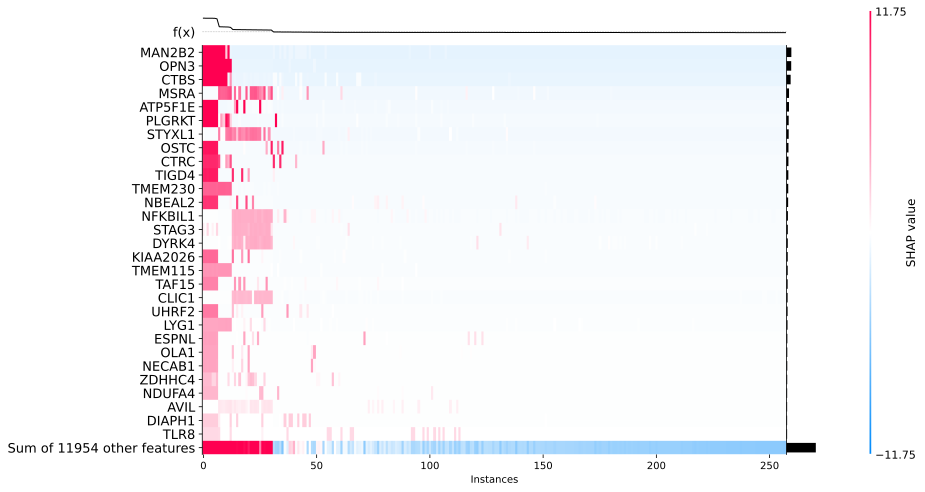

In [26]:
stage_one_mass_heatmap_path = locations.output.plots / "stage_one" / "heatmap_mass_unclustered.svg"
stage_one_mass.plot_heatmap(True, max_display = 30, figsize = (14,8), sort_by_clust=False, save=stage_one_mass_heatmap_path)

### MtGC ###

In [27]:
stage_one_mtGC = run_stage_one("mtGC")
stage_one_mtGC.selected

2020-10-10 02:41:26.873 | INFO     | yspecies.selection:fit:153 - ===== fitting models with seed 0 =====
2020-10-10 02:41:26.874 | INFO     | yspecies.selection:fit:154 - PARAMETERS:
{'bagging_fraction': 0.4882827581871194, 'boosting_type': 'gbdt', 'drop_rate': 0.16290376621758335, 'feature_fraction': 0.3059934876406196, 'lambda_l1': 0.017007142345511594, 'lambda_l2': 0.568546479848152, 'learning_rate': 0.08231879540454069, 'max_depth': 7, 'max_leaves': 24, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10}
2020-10-10 02:41:26.902 | INFO     | yspecies.selection:fit:157 - SEED: 0 | FOLD: 0 | VALIDATION_SPECIES: ['Callithrix_jacchus', 'Sus_scrofa']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[63]	valid_0's l1: 0.441211	valid_0's l2: 0.516391	valid_0's huber: 0.196681


2020-10-10 02:41:31.490 | INFO     | yspecies.selection:fit:157 - SEED: 0 | FOLD: 1 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Gorilla_gorilla']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[44]	valid_0's l1: 0.666014	valid_0's l2: 0.744224	valid_0's huber: 0.316382


2020-10-10 02:41:34.300 | INFO     | yspecies.selection:fit:157 - SEED: 0 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Equus_caballus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[115]	valid_0's l1: 0.489207	valid_0's l2: 0.880688	valid_0's huber: 0.266097


2020-10-10 02:41:39.732 | INFO     | yspecies.selection:fit:157 - SEED: 0 | FOLD: 3 | VALIDATION_SPECIES: ['Tupaia_belangeri', 'Ovis_aries']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[75]	valid_0's l1: 0.610399	valid_0's l2: 0.813965	valid_0's huber: 0.315184


2020-10-10 02:41:43.676 | INFO     | yspecies.selection:fit:157 - SEED: 0 | FOLD: 4 | VALIDATION_SPECIES: ['Capra_hircus', 'Macaca_fascicularis']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[145]	valid_0's l1: 0.432926	valid_0's l2: 0.491019	valid_0's huber: 0.195021


2020-10-10 02:41:55.004 | INFO     | yspecies.explanations:transform:566 - Metrics: 
Metrics(R2=0.9096028424902937, MAE=0.5279515341454875, MSE=0.6892571676741432, huber=0.25789016146700405)
2020-10-10 02:41:55.042 | INFO     | yspecies.selection:fit:153 - ===== fitting models with seed 1 =====
2020-10-10 02:41:55.043 | INFO     | yspecies.selection:fit:154 - PARAMETERS:
{'bagging_fraction': 0.4882827581871194, 'boosting_type': 'gbdt', 'drop_rate': 0.16290376621758335, 'feature_fraction': 0.3059934876406196, 'lambda_l1': 0.017007142345511594, 'lambda_l2': 0.568546479848152, 'learning_rate': 0.08231879540454069, 'max_depth': 7, 'max_leaves': 24, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 0}
2020-10-10 02:41:55.074 | INFO     | yspecies.selection:fit:157 - SEED: 1 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_nemestrina', 'Felis_catus']
Found `early_stopping_round` in params. Will use it instead of arg

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[166]	valid_0's l1: 0.337064	valid_0's l2: 0.304221	valid_0's huber: 0.124882


2020-10-10 02:42:00.880 | INFO     | yspecies.selection:fit:157 - SEED: 1 | FOLD: 1 | VALIDATION_SPECIES: ['Callithrix_jacchus', 'Heterocephalus_glaber']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[82]	valid_0's l1: 0.529638	valid_0's l2: 0.690563	valid_0's huber: 0.27286


2020-10-10 02:42:05.043 | INFO     | yspecies.selection:fit:157 - SEED: 1 | FOLD: 2 | VALIDATION_SPECIES: ['Tupaia_belangeri', 'Sus_scrofa']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[117]	valid_0's l1: 0.30368	valid_0's l2: 0.301533	valid_0's huber: 0.130421


2020-10-10 02:42:10.192 | INFO     | yspecies.selection:fit:157 - SEED: 1 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Bos_taurus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[81]	valid_0's l1: 0.386133	valid_0's l2: 0.32842	valid_0's huber: 0.147184


2020-10-10 02:42:14.205 | INFO     | yspecies.selection:fit:157 - SEED: 1 | FOLD: 4 | VALIDATION_SPECIES: ['Pan_troglodytes', 'Equus_caballus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[116]	valid_0's l1: 0.551207	valid_0's l2: 1.28332	valid_0's huber: 0.317704


2020-10-10 02:42:26.360 | INFO     | yspecies.explanations:transform:566 - Metrics: 
Metrics(R2=0.9259208071509757, MAE=0.4215445078553709, MSE=0.5816107919753601, huber=0.19858414026021537)
2020-10-10 02:42:26.404 | INFO     | yspecies.selection:fit:153 - ===== fitting models with seed 2 =====
2020-10-10 02:42:26.404 | INFO     | yspecies.selection:fit:154 - PARAMETERS:
{'bagging_fraction': 0.4882827581871194, 'boosting_type': 'gbdt', 'drop_rate': 0.16290376621758335, 'feature_fraction': 0.3059934876406196, 'lambda_l1': 0.017007142345511594, 'lambda_l2': 0.568546479848152, 'learning_rate': 0.08231879540454069, 'max_depth': 7, 'max_leaves': 24, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 1}
2020-10-10 02:42:26.432 | INFO     | yspecies.selection:fit:157 - SEED: 2 | FOLD: 0 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Sus_scrofa']
Found `early_stopping_round` in params. Will use it instead of 

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 0.464265	valid_0's l2: 0.450677	valid_0's huber: 0.205338
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 0.464265	valid_0's l2: 0.450677	valid_0's huber: 0.205338


2020-10-10 02:42:32.712 | INFO     | yspecies.selection:fit:157 - SEED: 2 | FOLD: 1 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Meriones_unguiculatus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[69]	valid_0's l1: 0.628644	valid_0's l2: 0.845603	valid_0's huber: 0.322842


2020-10-10 02:42:36.060 | INFO     | yspecies.selection:fit:157 - SEED: 2 | FOLD: 2 | VALIDATION_SPECIES: ['Felis_catus', 'Capra_hircus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[202]	valid_0's l1: 0.313176	valid_0's l2: 0.228994	valid_0's huber: 0.109116


2020-10-10 02:42:41.805 | INFO     | yspecies.selection:fit:157 - SEED: 2 | FOLD: 3 | VALIDATION_SPECIES: ['Equus_caballus', 'Pan_paniscus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 0.573041	valid_0's l2: 0.783143	valid_0's huber: 0.294711
Did not meet early stopping. Best iteration is:
[248]	valid_0's l1: 0.573039	valid_0's l2: 0.783199	valid_0's huber: 0.294725


2020-10-10 02:42:48.235 | INFO     | yspecies.selection:fit:157 - SEED: 2 | FOLD: 4 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Rattus_norvegicus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6]	valid_0's l1: 0.896294	valid_0's l2: 1.98642	valid_0's huber: 0.559482


2020-10-10 02:42:52.488 | INFO     | yspecies.explanations:transform:566 - Metrics: 
Metrics(R2=0.8495905023062649, MAE=0.5750837837327339, MSE=0.8589781977807881, huber=0.29184366090278485)
2020-10-10 02:42:52.520 | INFO     | yspecies.selection:fit:153 - ===== fitting models with seed 3 =====
2020-10-10 02:42:52.521 | INFO     | yspecies.selection:fit:154 - PARAMETERS:
{'bagging_fraction': 0.4882827581871194, 'boosting_type': 'gbdt', 'drop_rate': 0.16290376621758335, 'feature_fraction': 0.3059934876406196, 'lambda_l1': 0.017007142345511594, 'lambda_l2': 0.568546479848152, 'learning_rate': 0.08231879540454069, 'max_depth': 7, 'max_leaves': 24, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 2}
2020-10-10 02:42:52.545 | INFO     | yspecies.selection:fit:157 - SEED: 3 | FOLD: 0 | VALIDATION_SPECIES: ['Ursus_americanus', 'Phascolarctos_cinereus']
Found `early_stopping_round` in params. Will use it inst

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[64]	valid_0's l1: 0.631368	valid_0's l2: 0.975982	valid_0's huber: 0.340971


2020-10-10 02:42:55.955 | INFO     | yspecies.selection:fit:157 - SEED: 3 | FOLD: 1 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Macaca_mulatta']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[37]	valid_0's l1: 0.939213	valid_0's l2: 2.80595	valid_0's huber: 0.613162


2020-10-10 02:42:58.541 | INFO     | yspecies.selection:fit:157 - SEED: 3 | FOLD: 2 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Gorilla_gorilla']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[84]	valid_0's l1: 0.654389	valid_0's l2: 1.0303	valid_0's huber: 0.363442


2020-10-10 02:43:02.221 | INFO     | yspecies.selection:fit:157 - SEED: 3 | FOLD: 3 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Ovis_aries']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[14]	valid_0's l1: 0.797797	valid_0's l2: 0.943134	valid_0's huber: 0.398884


2020-10-10 02:43:03.778 | INFO     | yspecies.selection:fit:157 - SEED: 3 | FOLD: 4 | VALIDATION_SPECIES: ['Felis_catus', 'Tupaia_belangeri']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[100]	valid_0's l1: 0.514115	valid_0's l2: 0.69719	valid_0's huber: 0.262532


2020-10-10 02:43:10.276 | INFO     | yspecies.explanations:transform:566 - Metrics: 
Metrics(R2=0.8341894765322853, MAE=0.7073766577382179, MSE=1.2905113294373056, huber=0.3932043860966032)
2020-10-10 02:43:10.312 | INFO     | yspecies.selection:fit:153 - ===== fitting models with seed 4 =====
2020-10-10 02:43:10.313 | INFO     | yspecies.selection:fit:154 - PARAMETERS:
{'bagging_fraction': 0.4882827581871194, 'boosting_type': 'gbdt', 'drop_rate': 0.16290376621758335, 'feature_fraction': 0.3059934876406196, 'lambda_l1': 0.017007142345511594, 'lambda_l2': 0.568546479848152, 'learning_rate': 0.08231879540454069, 'max_depth': 7, 'max_leaves': 24, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 3}
2020-10-10 02:43:10.342 | INFO     | yspecies.selection:fit:157 - SEED: 4 | FOLD: 0 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Vombatus_ursinus']
Found `early_stopping_round` in params. Will use it instead

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[90]	valid_0's l1: 0.966295	valid_0's l2: 1.85149	valid_0's huber: 0.608075


2020-10-10 02:43:14.310 | INFO     | yspecies.selection:fit:157 - SEED: 4 | FOLD: 1 | VALIDATION_SPECIES: ['Mus_musculus', 'Macaca_nemestrina']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[92]	valid_0's l1: 1.11812	valid_0's l2: 2.38526	valid_0's huber: 0.740519


2020-10-10 02:43:17.729 | INFO     | yspecies.selection:fit:157 - SEED: 4 | FOLD: 2 | VALIDATION_SPECIES: ['Pan_troglodytes', 'Heterocephalus_glaber']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[82]	valid_0's l1: 0.632612	valid_0's l2: 1.11393	valid_0's huber: 0.364855


2020-10-10 02:43:21.577 | INFO     | yspecies.selection:fit:157 - SEED: 4 | FOLD: 3 | VALIDATION_SPECIES: ['Capra_hircus', 'Tupaia_belangeri']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[115]	valid_0's l1: 0.381807	valid_0's l2: 0.456091	valid_0's huber: 0.174989


2020-10-10 02:43:25.839 | INFO     | yspecies.selection:fit:157 - SEED: 4 | FOLD: 4 | VALIDATION_SPECIES: ['Equus_caballus', 'Oryctolagus_cuniculus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[104]	valid_0's l1: 0.45246	valid_0's l2: 0.826432	valid_0's huber: 0.241727


2020-10-10 02:43:36.889 | INFO     | yspecies.explanations:transform:566 - Metrics: 
Metrics(R2=0.8206571369840192, MAE=0.710258796243399, MSE=1.3266406260023853, huber=0.4260187211191223)
2020-10-10 02:43:36.923 | INFO     | yspecies.selection:fit:153 - ===== fitting models with seed 5 =====
2020-10-10 02:43:36.923 | INFO     | yspecies.selection:fit:154 - PARAMETERS:
{'bagging_fraction': 0.4882827581871194, 'boosting_type': 'gbdt', 'drop_rate': 0.16290376621758335, 'feature_fraction': 0.3059934876406196, 'lambda_l1': 0.017007142345511594, 'lambda_l2': 0.568546479848152, 'learning_rate': 0.08231879540454069, 'max_depth': 7, 'max_leaves': 24, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 4}
2020-10-10 02:43:36.952 | INFO     | yspecies.selection:fit:157 - SEED: 5 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Vombatus_ursinus']
Found `early_stopping_round` in params. Will use it instead of arg

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 0.495051	valid_0's l2: 0.717379	valid_0's huber: 0.248336
Did not meet early stopping. Best iteration is:
[249]	valid_0's l1: 0.495049	valid_0's l2: 0.717353	valid_0's huber: 0.248332


2020-10-10 02:43:44.002 | INFO     | yspecies.selection:fit:157 - SEED: 5 | FOLD: 1 | VALIDATION_SPECIES: ['Sus_scrofa', 'Rhinolophus_ferrumequinum']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[117]	valid_0's l1: 0.38329	valid_0's l2: 0.52572	valid_0's huber: 0.184356


2020-10-10 02:43:48.866 | INFO     | yspecies.selection:fit:157 - SEED: 5 | FOLD: 2 | VALIDATION_SPECIES: ['Meriones_unguiculatus', 'Bos_taurus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[102]	valid_0's l1: 0.449672	valid_0's l2: 0.484819	valid_0's huber: 0.208071


2020-10-10 02:43:54.265 | INFO     | yspecies.selection:fit:157 - SEED: 5 | FOLD: 3 | VALIDATION_SPECIES: ['Tupaia_belangeri', 'Heterocephalus_glaber']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[106]	valid_0's l1: 0.522958	valid_0's l2: 0.751042	valid_0's huber: 0.272434


2020-10-10 02:43:58.820 | INFO     | yspecies.selection:fit:157 - SEED: 5 | FOLD: 4 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Equus_caballus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[133]	valid_0's l1: 0.366709	valid_0's l2: 0.313237	valid_0's huber: 0.140446


2020-10-10 02:44:11.641 | INFO     | yspecies.explanations:transform:566 - Metrics: 
Metrics(R2=0.9254032182273864, MAE=0.44353558782810765, MSE=0.5584338989570872, huber=0.21073900029383466)
2020-10-10 02:44:11.676 | INFO     | yspecies.selection:fit:153 - ===== fitting models with seed 6 =====
2020-10-10 02:44:11.676 | INFO     | yspecies.selection:fit:154 - PARAMETERS:
{'bagging_fraction': 0.4882827581871194, 'boosting_type': 'gbdt', 'drop_rate': 0.16290376621758335, 'feature_fraction': 0.3059934876406196, 'lambda_l1': 0.017007142345511594, 'lambda_l2': 0.568546479848152, 'learning_rate': 0.08231879540454069, 'max_depth': 7, 'max_leaves': 24, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 5}
2020-10-10 02:44:11.706 | INFO     | yspecies.selection:fit:157 - SEED: 6 | FOLD: 0 | VALIDATION_SPECIES: ['Ursus_americanus', 'Tupaia_belangeri']
Found `early_stopping_round` in params. Will use it instead o

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[94]	valid_0's l1: 0.557634	valid_0's l2: 0.825282	valid_0's huber: 0.298737


2020-10-10 02:44:16.134 | INFO     | yspecies.selection:fit:157 - SEED: 6 | FOLD: 1 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Ailuropoda_melanoleuca']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[174]	valid_0's l1: 0.441261	valid_0's l2: 0.663204	valid_0's huber: 0.211398


2020-10-10 02:44:22.879 | INFO     | yspecies.selection:fit:157 - SEED: 6 | FOLD: 2 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Sus_scrofa']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[120]	valid_0's l1: 0.291525	valid_0's l2: 0.201244	valid_0's huber: 0.0948343


2020-10-10 02:44:28.062 | INFO     | yspecies.selection:fit:157 - SEED: 6 | FOLD: 3 | VALIDATION_SPECIES: ['Bos_taurus', 'Ictidomys_tridecemlineatus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[27]	valid_0's l1: 0.861738	valid_0's l2: 2.61326	valid_0's huber: 0.519205


2020-10-10 02:44:30.480 | INFO     | yspecies.selection:fit:157 - SEED: 6 | FOLD: 4 | VALIDATION_SPECIES: ['Pan_troglodytes', 'Felis_catus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[173]	valid_0's l1: 0.391897	valid_0's l2: 0.366019	valid_0's huber: 0.156606


2020-10-10 02:44:42.075 | INFO     | yspecies.explanations:transform:566 - Metrics: 
Metrics(R2=0.8759305464871419, MAE=0.5088110557282627, MSE=0.933801806205896, huber=0.25059788114136666)
2020-10-10 02:44:42.109 | INFO     | yspecies.selection:fit:153 - ===== fitting models with seed 7 =====
2020-10-10 02:44:42.109 | INFO     | yspecies.selection:fit:154 - PARAMETERS:
{'bagging_fraction': 0.4882827581871194, 'boosting_type': 'gbdt', 'drop_rate': 0.16290376621758335, 'feature_fraction': 0.3059934876406196, 'lambda_l1': 0.017007142345511594, 'lambda_l2': 0.568546479848152, 'learning_rate': 0.08231879540454069, 'max_depth': 7, 'max_leaves': 24, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 6}
2020-10-10 02:44:42.138 | INFO     | yspecies.selection:fit:157 - SEED: 7 | FOLD: 0 | VALIDATION_SPECIES: ['Sus_scrofa', 'Macaca_fascicularis']
Found `early_stopping_round` in params. Will use it instead of arg

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[155]	valid_0's l1: 0.329073	valid_0's l2: 0.245352	valid_0's huber: 0.116789


2020-10-10 02:44:47.097 | INFO     | yspecies.selection:fit:157 - SEED: 7 | FOLD: 1 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Meriones_unguiculatus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	valid_0's l1: 1.09618	valid_0's l2: 2.99324	valid_0's huber: 0.70736


2020-10-10 02:44:49.483 | INFO     | yspecies.selection:fit:157 - SEED: 7 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Ovis_aries']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[108]	valid_0's l1: 0.613027	valid_0's l2: 0.964913	valid_0's huber: 0.315854


2020-10-10 02:44:53.802 | INFO     | yspecies.selection:fit:157 - SEED: 7 | FOLD: 3 | VALIDATION_SPECIES: ['Mus_musculus', 'Equus_caballus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[98]	valid_0's l1: 0.808201	valid_0's l2: 1.13401	valid_0's huber: 0.466514


2020-10-10 02:44:58.206 | INFO     | yspecies.selection:fit:157 - SEED: 7 | FOLD: 4 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Heterocephalus_glaber']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[162]	valid_0's l1: 0.514094	valid_0's l2: 0.646242	valid_0's huber: 0.243737


2020-10-10 02:45:09.136 | INFO     | yspecies.explanations:transform:566 - Metrics: 
Metrics(R2=0.8350510466239834, MAE=0.6721150491236693, MSE=1.1967503698551947, huber=0.36307952102435276)
2020-10-10 02:45:09.174 | INFO     | yspecies.selection:fit:153 - ===== fitting models with seed 8 =====
2020-10-10 02:45:09.174 | INFO     | yspecies.selection:fit:154 - PARAMETERS:
{'bagging_fraction': 0.4882827581871194, 'boosting_type': 'gbdt', 'drop_rate': 0.16290376621758335, 'feature_fraction': 0.3059934876406196, 'lambda_l1': 0.017007142345511594, 'lambda_l2': 0.568546479848152, 'learning_rate': 0.08231879540454069, 'max_depth': 7, 'max_leaves': 24, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 7}
2020-10-10 02:45:09.205 | INFO     | yspecies.selection:fit:157 - SEED: 8 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Ailuropoda_melanoleuca']
Found `early_stopping_round` in params. Will use it instea

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[155]	valid_0's l1: 0.500272	valid_0's l2: 0.691785	valid_0's huber: 0.247581


2020-10-10 02:45:15.970 | INFO     | yspecies.selection:fit:157 - SEED: 8 | FOLD: 1 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Tupaia_belangeri']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[54]	valid_0's l1: 0.52535	valid_0's l2: 0.61728	valid_0's huber: 0.240626


2020-10-10 02:45:19.686 | INFO     | yspecies.selection:fit:157 - SEED: 8 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_nemestrina', 'Mesocricetus_auratus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 0.785434	valid_0's l2: 1.48332	valid_0's huber: 0.484037
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 0.785434	valid_0's l2: 1.48332	valid_0's huber: 0.484037


2020-10-10 02:45:28.799 | INFO     | yspecies.selection:fit:157 - SEED: 8 | FOLD: 3 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Ovis_aries']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[79]	valid_0's l1: 0.517472	valid_0's l2: 0.67778	valid_0's huber: 0.260115


2020-10-10 02:45:32.900 | INFO     | yspecies.selection:fit:157 - SEED: 8 | FOLD: 4 | VALIDATION_SPECIES: ['Bos_taurus', 'Oryctolagus_cuniculus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[88]	valid_0's l1: 0.425229	valid_0's l2: 0.472191	valid_0's huber: 0.186385


2020-10-10 02:45:42.687 | INFO     | yspecies.explanations:transform:566 - Metrics: 
Metrics(R2=0.8988612190374384, MAE=0.5507513040422383, MSE=0.7884716351808982, huber=0.2837962274946782)
2020-10-10 02:45:42.722 | INFO     | yspecies.selection:fit:153 - ===== fitting models with seed 9 =====
2020-10-10 02:45:42.722 | INFO     | yspecies.selection:fit:154 - PARAMETERS:
{'bagging_fraction': 0.4882827581871194, 'boosting_type': 'gbdt', 'drop_rate': 0.16290376621758335, 'feature_fraction': 0.3059934876406196, 'lambda_l1': 0.017007142345511594, 'lambda_l2': 0.568546479848152, 'learning_rate': 0.08231879540454069, 'max_depth': 7, 'max_leaves': 24, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 8}
2020-10-10 02:45:42.748 | INFO     | yspecies.selection:fit:157 - SEED: 9 | FOLD: 0 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Meriones_unguiculatus']
Found `early_stopping_round` in params. Will use it inste

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[31]	valid_0's l1: 0.872133	valid_0's l2: 1.03006	valid_0's huber: 0.447743


2020-10-10 02:45:44.703 | INFO     | yspecies.selection:fit:157 - SEED: 9 | FOLD: 1 | VALIDATION_SPECIES: ['Phascolarctos_cinereus', 'Pan_troglodytes']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[90]	valid_0's l1: 0.673474	valid_0's l2: 1.00705	valid_0's huber: 0.373538


2020-10-10 02:45:48.491 | INFO     | yspecies.selection:fit:157 - SEED: 9 | FOLD: 2 | VALIDATION_SPECIES: ['Ailuropoda_melanoleuca', 'Heterocephalus_glaber']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[123]	valid_0's l1: 0.541871	valid_0's l2: 0.742505	valid_0's huber: 0.282726


2020-10-10 02:45:54.436 | INFO     | yspecies.selection:fit:157 - SEED: 9 | FOLD: 3 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Cavia_porcellus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[45]	valid_0's l1: 1.06973	valid_0's l2: 2.0727	valid_0's huber: 0.662302


2020-10-10 02:45:57.208 | INFO     | yspecies.selection:fit:157 - SEED: 9 | FOLD: 4 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Vombatus_ursinus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[109]	valid_0's l1: 0.700989	valid_0's l2: 1.14192	valid_0's huber: 0.387133


2020-10-10 02:46:06.288 | INFO     | yspecies.explanations:transform:566 - Metrics: 
Metrics(R2=0.8274968211218413, MAE=0.7716386027961903, MSE=1.1988455579181634, huber=0.431154932501493)


symbol  repeats  mean_shap  mean_kendall_tau  shap_0  \
ENSG00000171121     KCNMB3   10.000     11.000             0.625  12.600   
ENSG00000144451     SPAG16   10.000      8.420             0.389   5.600   
ENSG00000023191       RNH1   10.000      3.520            -0.466   2.200   
ENSG00000122034      GTF3A    9.000     10.622             0.627  11.200   
ENSG00000006282    SPATA20    9.000      8.333             0.694   9.000   
ENSG00000154328      NEIL2    9.000      7.778             0.693   7.800   
ENSG00000168300     PCMTD1    8.000      9.700             0.133   9.000   
ENSG00000167272       POP5    8.000      7.425            -0.359   7.600   
ENSG00000188747      NOXA1    8.000      6.550             0.649   6.400   
ENSG00000196419      XRCC6    7.000     10.914             0.542   9.200   
ENSG00000178982      EIF3K    7.000      7.429             0.241   8.400   
ENSG00000164304      CAGE1    7.000      6.171            -0.668   6.400   
ENSG00000167515   TRAPPC2L    7.000      5.400            -0.498   4.200   
ENSG00000122952      ZWINT    7.000      3.486            -0.639   2.000   
ENSG00000156384       SFR1    6.000      5.833            -0.668   4.200   
ENSG00000176105       YES1    5.000      4.680             0.165   3.800   
ENSG00000163584    RPL22L1    5.000      4.240            -0.607     nan   
ENSG00000171747     LGALS4    5.000      4.040            -0.676     nan   
ENSG00000164362       TERT    5.000      3.760            -0.517   3.600   
ENSG00000048140    TSPAN17    5.000      3.720            -0.388     nan   
ENSG00000204954   C12orf73    5.000      3.120            -0.686     nan   
ENSG00000163528     CHCHD4    4.000      7.050             0.431     nan   
ENSG00000211454      AKR7L    4.000      5.450            -0.381   6.400   
ENSG00000177143      CETN1    4.000      4.950            -0.455   4.400   
ENSG00000129187       DCTD    4.000      3.150             0.676     nan   
ENSG00000164010      ERMAP    4.000      2.750             0.560     nan   
ENSG00000055950     MRPL43    4.000      1.950             0.424     nan   
ENSG00000143443    C1orf56    4.000      1.750             0.619   1.200   
ENSG00000155906      RMND1    4.000      1.750             0.549     nan   
ENSG00000154582       ELOC    3.000      4.867            -0.595     nan   
ENSG00000137038      DMAC1    3.000      3.667            -0.679     nan   
ENSG00000138678      GPAT3    3.000      3.533             0.055   3.400   
ENSG00000069869      NEDD4    3.000      3.467            -0.475     nan   
ENSG00000069275     NUCKS1    3.000      2.933             0.247     nan   
ENSG00000151006     PRSS53    3.000      2.733             0.567     nan   
ENSG00000160447       PKN3    3.000      2.600             0.629     nan   
ENSG00000154485      MMP21    3.000      2.200             0.669     nan   
ENSG00000008324     SS18L2    3.000      2.067            -0.649     nan   
ENSG00000174348       PODN    3.000      1.867             0.396     nan   
ENSG00000213719      CLIC1    3.000      1.800            -0.392     nan   
ENSG00000142937       RPS8    3.000      1.600             0.476   1.600   
ENSG00000174695   TMEM167A    3.000      1.400             0.581     nan   
ENSG00000242866       STRC    2.000      3.100             0.668     nan   
ENSG00000101190      TCFL5    2.000      2.900             0.593     nan   
ENSG00000139618      BRCA2    2.000      2.700            -0.313     nan   
ENSG00000100908       EMC9    2.000      2.600            -0.633     nan   
ENSG00000203710        CR1    2.000      2.500            -0.540     nan   
ENSG00000120992     LYPLA1    2.000      2.400            -0.355     nan   
ENSG00000171135      JAGN1    2.000      2.400            -0.596     nan   
ENSG00000197629      MPEG1    2.000      2.400            -0.653     nan   
ENSG00000120594     PLXDC2    2.000      2.300             0.311     nan   
ENSG00000135845       PIGC    2.000      2.300            -0.378    

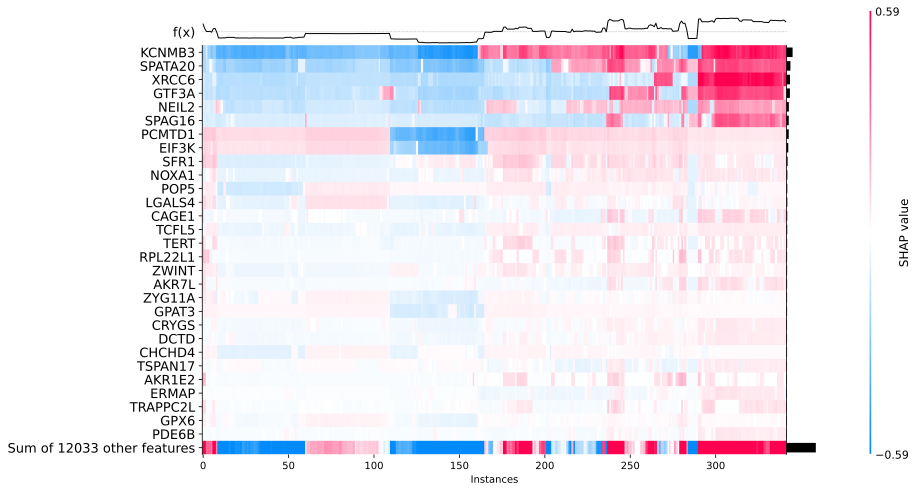

In [30]:
stage_one_gc_heatmap_path = locations.output.plots / "stage_one" / "heatmap_gc.svg"
stage_one_mtGC.plot_heatmap(True, max_display = 30, figsize = (14,8), sort_by_clust=True, save=stage_one_gc_heatmap_path)

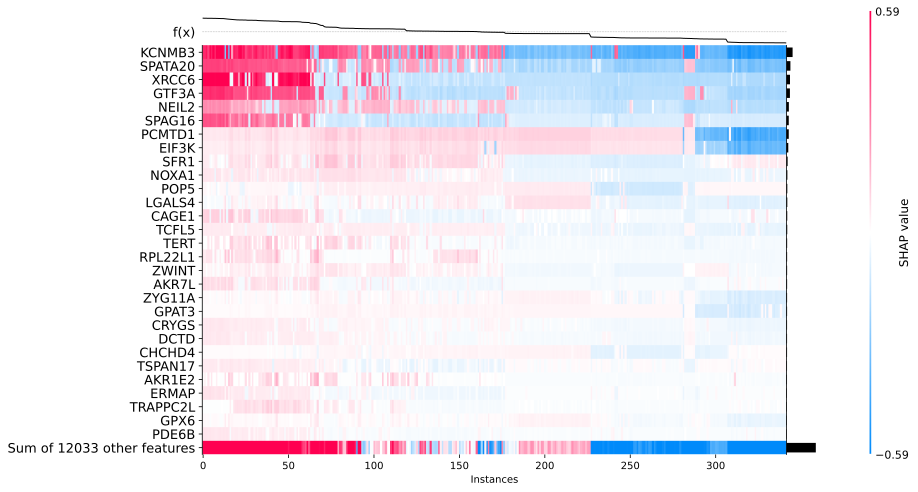

In [29]:
stage_one_gc_heatmap_unclustered_path = locations.output.plots / "stage_one" / "heatmap_gc_unclustered.svg"
stage_one_mtGC.plot_heatmap(True, max_display = 30, figsize = (14,8), sort_by_clust=False, save=stage_one_gc_heatmap_unclustered_path)

### Metabolism ###

In [1]:
stage_one_metabolic_rate = run_stage_one("metabolic_rate")
stage_one_metabolic_rate.selected

NameError: name 'run_stage_one' is not defined

In [ ]:
stage_one_metabolic_rate_heatmap_path = locations.output.plots / "stage_one" / "heatmap_metabolic_rate_unclustered.svg"
stage_one_metabolic_rate.plot_heatmap(True, max_display = 30, figsize = (14,8), sort_by_clust=False, save=stage_one_metabolic_rate_heatmap_path)

### Temperature ###

In [ ]:
stage_one_temperature = run_stage_one("temperature")
stage_one_temperature.selected

In [ ]:
stage_one_temperature_heatmap_path = locations.output.plots / "stage_one" / "heatmap_temperature_unclustered.svg"
stage_one_temperature.plot_heatmap(True, max_display = 30, figsize = (14,8), sort_by_clust=False, save=stage_one_temperature_heatmap_path)

### Gestation ###

In [ ]:
stage_one_gestation = run_stage_one("gestation_days")
stage_one_gestation.selected

In [ ]:
stage_one_gestation_heatmap_path = locations.output.plots / "stage_one" / "heatmap_gestation.svg"
stage_one_gestation.plot_heatmap(True, max_display = 30, figsize = (14,8), sort_by_clust=True, save=stage_one_gestation_heatmap_path)

In [ ]:
stage_one_gestation_heatmap_unclustered_path = locations.output.plots / "stage_one" / "heatmap_gestation_unclustered.svg"
stage_one_gestation.plot_heatmap(True, max_display = 30, figsize = (14,8), sort_by_clust=False, save=stage_one_gestation_heatmap_unclustered_path)

## Intersect first stages ##

In [37]:
genes = FeatureSummary.concat(stage_one, 2)
genes.shape

(146,)

In [38]:
stage_one["lifespan"].selected.columns

Index(['symbol', 'repeats', 'mean_shap', 'mean_kendall_tau', 'shap_0',
       'kendall_tau_0', 'shap_1', 'kendall_tau_1', 'shap_2', 'kendall_tau_2',
       'shap_3', 'kendall_tau_3', 'shap_4', 'kendall_tau_4', 'shap_5',
       'kendall_tau_5', 'shap_6', 'kendall_tau_6', 'shap_7', 'kendall_tau_7',
       'shap_8', 'kendall_tau_8', 'shap_9', 'kendall_tau_9'],
      dtype='object')

In [39]:
df = genes.to_frame()
for key, stage in stage_one.items():
    df = df.join(stage.selected["mean_kendall_tau"], how="left", rsuffix="_"+key)
for key, stage in stage_one.items():
    df = df.join(stage.selected["mean_shap"], how="left", rsuffix="_"+key)
df

symbol  mean_kendall_tau  mean_kendall_tau_mass_kg  \
ENSG00000010219     DYRK4             0.263                     0.212   
ENSG00000204498   NFKBIL1            -0.141                    -0.193   
ENSG00000066923     STAG3             0.438                     0.154   
ENSG00000185880    TRIM69             0.140                       nan   
ENSG00000105672      ETV2             0.730                       nan   
ENSG00000167515  TRAPPC2L            -0.168                       nan   
ENSG00000171121    KCNMB3             0.667                       nan   
ENSG00000132436    FIGNL1             0.544                       nan   
ENSG00000157343    ARMC12             0.629                       nan   
ENSG00000170835       CEL             0.694                       nan   
ENSG00000188747     NOXA1             0.692                       nan   
ENSG00000106554    CHCHD3            -0.381                       nan   
ENSG00000164362      TERT            -0.444                       nan   
ENSG00000129187      DCTD             0.624                       nan   
ENSG00000144451    SPAG16             0.475                       nan   
ENSG00000172531    PPP1CA            -0.712                       nan   
ENSG00000013288    MAN2B2            -0.301                       nan   
ENSG00000160948     VPS28            -0.329                       nan   
ENSG00000023191      RNH1            -0.319                       nan   
ENSG00000165555   NOXRED1             0.799                       nan   
ENSG00000108384    RAD51C             0.388                     0.173   
ENSG00000142002      DPP9            -0.703                       nan   
ENSG00000152705  CATSPER3             0.684                       nan   
ENSG00000132464      ENAM             0.491                       nan   
ENSG00000066926      FECH            -0.421                       nan   
ENSG00000136436  CALCOCO2             0.684                       nan   
ENSG00000184983    NDUFA6            -0.638                       nan   
ENSG00000165501      LRR1             0.658                       nan   
ENSG00000164879       CA3            -0.435                       nan   
ENSG00000182612   TSPAN10             0.453                       nan   
ENSG00000137343     ATAT1            -0.403                       nan   
ENSG00000142541    RPL13A            -0.185                       nan   
ENSG00000213719     CLIC1            -0.252                    -0.091   
ENSG00000102265     TIMP1             0.589                     0.031   
ENSG00000108786   HSD17B1             0.651                       nan   
ENSG00000140398     NEIL1             0.481                       nan   
ENSG00000144214      LYG1               nan                     0.408   
ENSG00000124172   ATP5F1E            -0.280                    -0.299   
ENSG00000054277      OPN3               nan                     0.150   
ENSG00000126062   TMEM115               nan                     0.005   
ENSG00000107020    PLGRKT               nan                     0.015   
ENSG00000270647     TAF15               nan                     0.043   
ENSG00000152214      RIT2               nan                     0.065   
ENSG00000164304     CAGE1               nan                    -0.191   
ENSG00000117151      CTBS               nan                    -0.268   
ENSG00000101104   PABPC1L               nan                     0.308   
ENSG00000122034     GTF3A               nan                       nan   
ENSG00000196419     XRCC6               nan                       nan   
ENSG00000163528    CHCHD4               nan                       nan   
ENSG00000167272      POP5               nan                       nan   
ENSG00000122952     ZWINT               nan                       nan   
ENSG00000069869     NEDD4               nan                       nan   
ENSG00000168300    PCMTD1               nan                       nan   
ENSG00000006282   SPATA20               nan                       nan   
ENSG

In [40]:
genes.to_list()

['DYRK4',
 'NFKBIL1',
 'STAG3',
 'TRIM69',
 'ETV2',
 'TRAPPC2L',
 'KCNMB3',
 'FIGNL1',
 'ARMC12',
 'CEL',
 'NOXA1',
 'CHCHD3',
 'TERT',
 'DCTD',
 'SPAG16',
 'PPP1CA',
 'MAN2B2',
 'VPS28',
 'RNH1',
 'NOXRED1',
 'RAD51C',
 'DPP9',
 'CATSPER3',
 'ENAM',
 'FECH',
 'CALCOCO2',
 'NDUFA6',
 'LRR1',
 'CA3',
 'TSPAN10',
 'ATAT1',
 'RPL13A',
 'CLIC1',
 'TIMP1',
 'HSD17B1',
 'NEIL1',
 'LYG1',
 'ATP5F1E',
 'OPN3',
 'TMEM115',
 'PLGRKT',
 'TAF15',
 'RIT2',
 'CAGE1',
 'CTBS',
 'PABPC1L',
 'GTF3A',
 'XRCC6',
 'CHCHD4',
 'POP5',
 'ZWINT',
 'NEDD4',
 'PCMTD1',
 'SPATA20',
 'NEIL2',
 'EIF3K',
 'YES1',
 'LGALS4',
 'SFR1',
 'MRPL43',
 'TSPAN17',
 'AKR7L',
 'TCFL5',
 'CETN1',
 'GPAT3',
 'ELOC',
 'ATP5PD',
 'CAPN3',
 'MOSPD1',
 'PRSS53',
 'ZC3H15',
 'EMC9',
 'MRPL45',
 'PARP4',
 'PKN3',
 'YIPF6',
 'TSPAN31',
 'YWHAQ',
 'CALR3',
 'DTYMK',
 'PSMG3',
 'C12orf73',
 'STRC',
 'MPEG1',
 'RPL22L1',
 'PLXDC2',
 'ERMAP',
 'RPS17',
 'LYPLA1',
 'TESC',
 'DMAC1',
 'BRCA2',
 'AKR1E2',
 'RPL28',
 'NUCKS1',
 'UPP2',
 'MSRA',
 'STYXL1',
 'TMEM258',
 'UQCRB',
 'APRT',
 'CENPT',
 'MLYCD',
 'NDUFA4',
 'NDUFAF2',
 'RBFA',
 'CCR3',
 'USB1',
 'ZDHHC12',
 'C6orf89',
 'VMO1',
 'SLC25A43',
 'CHRNE',
 'GNAS',
 'TAF12',
 'TIMM8A',
 'RTCB',
 'PTGR1',
 'BTF3L4',
 'PSMD8',
 'PRDX1',
 'BRDT',
 'GPR160',
 'FAM161A',
 'DNAJB6',
 'RPL35',
 'SNAP23',
 'GNB1L',
 'SARNP',
 'PIGV',
 'CCDC15',
 'CNPY3',
 'MEMO1',
 'SEC11C',
 'MPC1',
 'DNAJC15',
 'GPT',
 'TMEM223',
 'CREB3L4',
 'NSL1',
 'MMP21',
 'MRTO4',
 'LHX8',
 'ZSWIM7',
 'RPS8',
 'XRCC5']

## Second stage selection ##

In [41]:
lifespan_selection = selections["lifespan"]

In [42]:
initial_data = lifespan_selection[0] #.by_genes()

In [43]:
genes.to_csv(locations.interim.stage_one / "results_concatenated.tsv", sep="\t", index_label="reference_gene")

In [44]:
stage_two_data = initial_data.by_genes.collect(lambda gs: gs.loc[genes.index.to_list()])
stage_two_data.name = "input"
stage_two_data

<table border='2'><caption>input<caption><tr><th>expressions</th><th>genes</th><th>species</th><th>samples</th><th>Genes Metadata</th><th>Species Metadata</th></tr><tr><td>(408, 146)</td><td>(146, 37)</td><td>38</td><td>408</td><td>(146, 2)</td><td>(38, 18)</td></tr></table>

In [45]:
stage_two_data.write(locations.interim.stage_two)

written input dataset content to ../data/interim/stage_2/input


PosixPath('../data/interim/stage_2/input')

In [46]:
stage_two_selection = (stage_two_data,lifespan_selection[1])

# Check untuned performance #

In [47]:
summary_stage_one_plot_path = locations.output.plots / "stage_one_summary_lifespan.svg"
summary_stage_one = stage_one["lifespan"]
stage_one_figure = summary_stage_one.plot(max_display=50, plot_size=0.5, save = summary_stage_one_plot_path)
stage_one_figure

### Saving stage 1 results ###

In [48]:
for k, v in stage_one.items():
    res = v.select_repeated(2)
    res.to_csv(locations.output.stage_one / f"{k}_selected.tsv", sep="\t", index_label="reference_gene")

In [49]:
stage_one["lifespan"].select_repeated(2)

symbol  repeats  mean_shap  mean_kendall_tau  shap_0  \
ENSG00000010219     DYRK4   10.000      8.375             0.263   8.250   
ENSG00000204498   NFKBIL1   10.000      7.350            -0.141   5.500   
ENSG00000066923     STAG3   10.000      5.525             0.438   5.250   
ENSG00000185880    TRIM69   10.000      5.200             0.140   5.250   
ENSG00000105672      ETV2   10.000      3.550             0.730   2.750   
ENSG00000167515  TRAPPC2L    9.000      6.056            -0.168     nan   
ENSG00000171121    KCNMB3    9.000      4.056             0.667   5.250   
ENSG00000132436    FIGNL1    9.000      3.722             0.544   4.250   
ENSG00000157343    ARMC12    9.000      2.639             0.629   3.000   
ENSG00000170835       CEL    8.000      3.219             0.694   2.500   
ENSG00000188747     NOXA1    8.000      2.656             0.692   1.250   
ENSG00000106554    CHCHD3    7.000      2.929            -0.381     nan   
ENSG00000164362      TERT    7.000      2.893            -0.444   2.250   
ENSG00000129187      DCTD    7.000      1.607             0.624     nan   
ENSG00000144451    SPAG16    6.000      3.625             0.475     nan   
ENSG00000172531    PPP1CA    5.000      2.700            -0.712   2.000   
ENSG00000013288    MAN2B2    5.000      2.650            -0.301     nan   
ENSG00000160948     VPS28    5.000      2.250            -0.329   3.500   
ENSG00000023191      RNH1    4.000      4.000            -0.319     nan   
ENSG00000165555   NOXRED1    4.000      3.938             0.799     nan   
ENSG00000108384    RAD51C    4.000      3.438             0.388     nan   
ENSG00000142002      DPP9    4.000      2.500            -0.703   2.250   
ENSG00000152705  CATSPER3    4.000      2.062             0.684     nan   
ENSG00000132464      ENAM    4.000      2.000             0.491   2.000   
ENSG00000066926      FECH    4.000      1.875            -0.421   1.250   
ENSG00000136436  CALCOCO2    4.000      1.500             0.684     nan   
ENSG00000184983    NDUFA6    3.000      2.750            -0.638     nan   
ENSG00000165501      LRR1    3.000      2.250             0.658     nan   
ENSG00000164879       CA3    3.000      1.083            -0.435     nan   
ENSG00000182612   TSPAN10    2.000      3.875             0.453     nan   
ENSG00000137343     ATAT1    2.000      2.875            -0.403     nan   
ENSG00000142541    RPL13A    2.000      2.625            -0.185   2.750   
ENSG00000213719     CLIC1    2.000      2.500            -0.252     nan   
ENSG00000102265     TIMP1    2.000      2.000             0.589   1.500   
ENSG00000108786   HSD17B1    2.000      1.875             0.651   1.750   
ENSG00000140398     NEIL1    2.000      1.750             0.481     nan   

                 kendall_tau_0  shap_1  kendall_tau_1  shap_2  kendall_tau_2  \
ENSG00000010219          0.261   8.000          0.249   8.000          0.211   
ENSG00000204498         -0.057   8.750         -0.030   7.250         -0.114   
ENSG00000066923          0.378   4.000          0.397   8.500          0.447   
ENSG00000185880          0.073   4.500          0.313   3.750          0.119   
ENSG00000105672          0.752   3.250          0.769   2.750          0.729   
ENSG00000167515            nan   4.750         -0.205   4.750         -0.137   
ENSG00000171121          0.725   3.750          0.660     nan            nan   
ENSG00000132436          0.475   3.000          0.563     nan            nan   
ENSG00000157343          0.625   2.000          0.632     nan            nan   
ENSG00000170835          0.738   3.500          0.748     nan            nan   
ENSG00000188747          0.718   2.250          0.699   1.500          0.761   
ENSG00000106554            nan     nan            nan   4.500         -0.362   
ENSG00000164362         -0.360   2.250         -0.411     nan            nan   
ENSG00000129187            nan   1.750          0.629   1.500          0.631   
ENSG00000144451            nan   2.500     

In [50]:
result_untuned = pipelines["lifespan"].fit_transform(stage_two_selection)
result_untuned.selected

2020-09-20 23:37:25.088 | INFO     | yspecies.selection:fit:149 - ===== fitting models with seed 0 =====
2020-09-20 23:37:25.089 | INFO     | yspecies.selection:fit:150 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 9}
2020-09-20 23:37:25.093 | INFO     | yspecies.selection:fit:153 - SEED: 0 | FOLD: 0 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Pan_paniscus']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[174]	valid_0's l1: 6.90108	valid_0's l2: 131.304	valid_0's huber: 5.86816


2020-09-20 23:37:25.302 | INFO     | yspecies.selection:fit:153 - SEED: 0 | FOLD: 1 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Capra_hircus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[190]	valid_0's l1: 3.75887	valid_0's l2: 58.3611	valid_0's huber: 3.05272


2020-09-20 23:37:25.463 | INFO     | yspecies.selection:fit:153 - SEED: 0 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Otolemur_garnettii']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[101]	valid_0's l1: 2.83112	valid_0's l2: 21.4317	valid_0's huber: 2.19768


2020-09-20 23:37:25.564 | INFO     | yspecies.selection:fit:153 - SEED: 0 | FOLD: 3 | VALIDATION_SPECIES: ['Macaca_nemestrina', 'Microcebus_murinus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[151]	valid_0's l1: 3.48658	valid_0's l2: 46.9042	valid_0's huber: 2.79185


2020-09-20 23:37:41.139 | INFO     | yspecies.explanations:transform:494 - Metrics: 
Metrics(R2=0.9137749568751992, MAE=4.2444128720269765, MSE=64.50024252867222, huber=3.4770081830380475)
2020-09-20 23:37:41.145 | INFO     | yspecies.selection:fit:149 - ===== fitting models with seed 1 =====
2020-09-20 23:37:41.145 | INFO     | yspecies.selection:fit:150 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 0}
2020-09-20 23:37:41.149 | INFO     | yspecies.selection:fit:153 - SEED: 1 | FOLD: 0 | VALIDATION_SPECIES: ['Felis_catus', 'Ursus_americanus']
Found `early_stopping_round` in params. Will use it instead of argument

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[97]	valid_0's l1: 3.50553	valid_0's l2: 28.1342	valid_0's huber: 2.79558


2020-09-20 23:37:41.262 | INFO     | yspecies.selection:fit:153 - SEED: 1 | FOLD: 1 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Vombatus_ursinus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[96]	valid_0's l1: 3.85661	valid_0's l2: 49.9451	valid_0's huber: 3.12172


2020-09-20 23:37:41.634 | INFO     | yspecies.selection:fit:153 - SEED: 1 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Rhinopithecus_bieti']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[182]	valid_0's l1: 2.51189	valid_0's l2: 21.5583	valid_0's huber: 1.94063


2020-09-20 23:37:41.810 | INFO     | yspecies.selection:fit:153 - SEED: 1 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Ovis_aries']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[116]	valid_0's l1: 4.72327	valid_0's l2: 84.0359	valid_0's huber: 3.90029


2020-09-20 23:37:55.155 | INFO     | yspecies.explanations:transform:494 - Metrics: 
Metrics(R2=0.9346116101693953, MAE=3.649327325891253, MSE=45.91836508168694, huber=2.9372888685120433)
2020-09-20 23:37:55.162 | INFO     | yspecies.selection:fit:149 - ===== fitting models with seed 2 =====
2020-09-20 23:37:55.163 | INFO     | yspecies.selection:fit:150 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 1}
2020-09-20 23:37:55.166 | INFO     | yspecies.selection:fit:153 - SEED: 2 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ursus_americanus']
Found `early_stopping_round` in params. Will use it instead of a

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[89]	valid_0's l1: 2.95259	valid_0's l2: 18	valid_0's huber: 2.30696


2020-09-20 23:37:55.273 | INFO     | yspecies.selection:fit:153 - SEED: 2 | FOLD: 1 | VALIDATION_SPECIES: ['Aotus_nancymaae', 'Phascolarctos_cinereus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[130]	valid_0's l1: 4.58283	valid_0's l2: 74.505	valid_0's huber: 3.76862


2020-09-20 23:37:55.410 | INFO     | yspecies.selection:fit:153 - SEED: 2 | FOLD: 2 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Ailuropoda_melanoleuca']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[129]	valid_0's l1: 2.79642	valid_0's l2: 17.854	valid_0's huber: 2.16112


2020-09-20 23:37:55.531 | INFO     | yspecies.selection:fit:153 - SEED: 2 | FOLD: 3 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Monodelphis_domestica']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[199]	valid_0's l1: 5.90852	valid_0's l2: 83.323	valid_0's huber: 4.9388


2020-09-20 23:38:10.338 | INFO     | yspecies.explanations:transform:494 - Metrics: 
Metrics(R2=0.919323478673826, MAE=4.0600901568897, MSE=48.420470607176085, huber=3.2934856202828464)
2020-09-20 23:38:10.344 | INFO     | yspecies.selection:fit:149 - ===== fitting models with seed 3 =====
2020-09-20 23:38:10.344 | INFO     | yspecies.selection:fit:150 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 2}
2020-09-20 23:38:10.347 | INFO     | yspecies.selection:fit:153 - SEED: 3 | FOLD: 0 | VALIDATION_SPECIES: ['Microcebus_murinus', 'Pan_paniscus']
Found `early_stopping_round` in params. Will use it instead of argument

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[63]	valid_0's l1: 4.1282	valid_0's l2: 41.6727	valid_0's huber: 3.36835


2020-09-20 23:38:10.425 | INFO     | yspecies.selection:fit:153 - SEED: 3 | FOLD: 1 | VALIDATION_SPECIES: ['Ursus_americanus', 'Gorilla_gorilla']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[142]	valid_0's l1: 6.83422	valid_0's l2: 139.264	valid_0's huber: 5.79754


2020-09-20 23:38:10.549 | INFO     | yspecies.selection:fit:153 - SEED: 3 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Capra_hircus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[210]	valid_0's l1: 2.9705	valid_0's l2: 23.8371	valid_0's huber: 2.33825


2020-09-20 23:38:10.724 | INFO     | yspecies.selection:fit:153 - SEED: 3 | FOLD: 3 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Mus_musculus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[114]	valid_0's l1: 2.6368	valid_0's l2: 38.6481	valid_0's huber: 2.01823


2020-09-20 23:38:23.209 | INFO     | yspecies.explanations:transform:494 - Metrics: 
Metrics(R2=0.9185389280703036, MAE=4.142429388349339, MSE=60.85536660835113, huber=3.3804607311703085)
2020-09-20 23:38:23.214 | INFO     | yspecies.selection:fit:149 - ===== fitting models with seed 4 =====
2020-09-20 23:38:23.214 | INFO     | yspecies.selection:fit:150 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 3}
2020-09-20 23:38:23.217 | INFO     | yspecies.selection:fit:153 - SEED: 4 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Pan_troglodytes']
Found `early_stopping_round` in params. Will use it instead of ar

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[123]	valid_0's l1: 2.90772	valid_0's l2: 26.2012	valid_0's huber: 2.28361


2020-09-20 23:38:23.332 | INFO     | yspecies.selection:fit:153 - SEED: 4 | FOLD: 1 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ursus_americanus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[156]	valid_0's l1: 3.38795	valid_0's l2: 52.8589	valid_0's huber: 2.71521


2020-09-20 23:38:23.474 | INFO     | yspecies.selection:fit:153 - SEED: 4 | FOLD: 2 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Cavia_aperea']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 3.91486	valid_0's l2: 38.7828	valid_0's huber: 3.18373
Did not meet early stopping. Best iteration is:
[249]	valid_0's l1: 3.91392	valid_0's l2: 38.7724	valid_0's huber: 3.18311


2020-09-20 23:38:23.689 | INFO     | yspecies.selection:fit:153 - SEED: 4 | FOLD: 3 | VALIDATION_SPECIES: ['Pan_paniscus', 'Gorilla_gorilla']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[131]	valid_0's l1: 5.03286	valid_0's l2: 76.9463	valid_0's huber: 4.18141


2020-09-20 23:38:37.099 | INFO     | yspecies.explanations:transform:494 - Metrics: 
Metrics(R2=0.9325217039193527, MAE=3.810611984303197, MSE=48.69471217680294, huber=3.0896790831643317)
2020-09-20 23:38:37.104 | INFO     | yspecies.selection:fit:149 - ===== fitting models with seed 5 =====
2020-09-20 23:38:37.105 | INFO     | yspecies.selection:fit:150 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 4}
2020-09-20 23:38:37.108 | INFO     | yspecies.selection:fit:153 - SEED: 5 | FOLD: 0 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Canis_lupus_familiaris']
Found `early_stopping_round` in params. Will use it instead of 

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[96]	valid_0's l1: 2.82999	valid_0's l2: 19.8658	valid_0's huber: 2.19672


2020-09-20 23:38:37.215 | INFO     | yspecies.selection:fit:153 - SEED: 5 | FOLD: 1 | VALIDATION_SPECIES: ['Ovis_aries', 'Heterocephalus_glaber']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[132]	valid_0's l1: 4.90723	valid_0's l2: 77.9842	valid_0's huber: 4.06406


2020-09-20 23:38:37.337 | INFO     | yspecies.selection:fit:153 - SEED: 5 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Oryctolagus_cuniculus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[161]	valid_0's l1: 4.61114	valid_0's l2: 67.8876	valid_0's huber: 3.81419


2020-09-20 23:38:37.487 | INFO     | yspecies.selection:fit:153 - SEED: 5 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_aperea', 'Ailuropoda_melanoleuca']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[143]	valid_0's l1: 4.06796	valid_0's l2: 54.6372	valid_0's huber: 3.33476


2020-09-20 23:38:51.954 | INFO     | yspecies.explanations:transform:494 - Metrics: 
Metrics(R2=0.9242027226313853, MAE=4.104079533451582, MSE=55.09370510753162, huber=3.3492921091435246)
2020-09-20 23:38:51.960 | INFO     | yspecies.selection:fit:149 - ===== fitting models with seed 6 =====
2020-09-20 23:38:51.960 | INFO     | yspecies.selection:fit:150 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 5}
2020-09-20 23:38:51.964 | INFO     | yspecies.selection:fit:153 - SEED: 6 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Heterocephalus_glaber']
Found `early_stopping_round` in params. Will use it i

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[125]	valid_0's l1: 3.03389	valid_0's l2: 32.0873	valid_0's huber: 2.40353


2020-09-20 23:38:52.090 | INFO     | yspecies.selection:fit:153 - SEED: 6 | FOLD: 1 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Suricata_suricatta']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[161]	valid_0's l1: 3.83399	valid_0's l2: 46.2392	valid_0's huber: 3.10285


2020-09-20 23:38:52.256 | INFO     | yspecies.selection:fit:153 - SEED: 6 | FOLD: 2 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ovis_aries']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[93]	valid_0's l1: 2.39365	valid_0's l2: 21.1445	valid_0's huber: 1.83508


2020-09-20 23:38:52.385 | INFO     | yspecies.selection:fit:153 - SEED: 6 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Pan_troglodytes']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[168]	valid_0's l1: 3.3345	valid_0's l2: 46.4976	valid_0's huber: 2.65443


2020-09-20 23:39:06.489 | INFO     | yspecies.explanations:transform:494 - Metrics: 
Metrics(R2=0.9493984552436938, MAE=3.1490053666051807, MSE=36.49214289011746, huber=2.4992991589310862)
2020-09-20 23:39:06.496 | INFO     | yspecies.selection:fit:149 - ===== fitting models with seed 7 =====
2020-09-20 23:39:06.496 | INFO     | yspecies.selection:fit:150 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 6}
2020-09-20 23:39:06.500 | INFO     | yspecies.selection:fit:153 - SEED: 7 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Cavia_porcellus']
Found `early_stopping_round` in params. Will use it instead of argume

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[93]	valid_0's l1: 3.11999	valid_0's l2: 23.8385	valid_0's huber: 2.4539


2020-09-20 23:39:06.618 | INFO     | yspecies.selection:fit:153 - SEED: 7 | FOLD: 1 | VALIDATION_SPECIES: ['Pan_paniscus', 'Capra_hircus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[101]	valid_0's l1: 3.98229	valid_0's l2: 55.6308	valid_0's huber: 3.23958


2020-09-20 23:39:06.716 | INFO     | yspecies.selection:fit:153 - SEED: 7 | FOLD: 2 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ictidomys_tridecemlineatus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[107]	valid_0's l1: 3.21462	valid_0's l2: 27.4638	valid_0's huber: 2.55376


2020-09-20 23:39:06.822 | INFO     | yspecies.selection:fit:153 - SEED: 7 | FOLD: 3 | VALIDATION_SPECIES: ['Canis_lupus_familiaris', 'Ursus_americanus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[112]	valid_0's l1: 3.6254	valid_0's l2: 44.8644	valid_0's huber: 2.92077


2020-09-20 23:39:18.520 | INFO     | yspecies.explanations:transform:494 - Metrics: 
Metrics(R2=0.9477711297035911, MAE=3.48557371840759, MSE=37.94937812551114, huber=2.792657984177728)
2020-09-20 23:39:18.527 | INFO     | yspecies.selection:fit:149 - ===== fitting models with seed 8 =====
2020-09-20 23:39:18.528 | INFO     | yspecies.selection:fit:150 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 7}
2020-09-20 23:39:18.531 | INFO     | yspecies.selection:fit:153 - SEED: 8 | FOLD: 0 | VALIDATION_SPECIES: ['Pan_paniscus', 'Suricata_suricatta']
Found `early_stopping_round` in params. Will use it instead of argument

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[87]	valid_0's l1: 2.80383	valid_0's l2: 21.3084	valid_0's huber: 2.18664


2020-09-20 23:39:18.641 | INFO     | yspecies.selection:fit:153 - SEED: 8 | FOLD: 1 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Tupaia_belangeri']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[132]	valid_0's l1: 3.21242	valid_0's l2: 34.4413	valid_0's huber: 2.56721


2020-09-20 23:39:18.767 | INFO     | yspecies.selection:fit:153 - SEED: 8 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Capra_hircus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[231]	valid_0's l1: 2.88122	valid_0's l2: 26.5532	valid_0's huber: 2.2766


2020-09-20 23:39:18.954 | INFO     | yspecies.selection:fit:153 - SEED: 8 | FOLD: 3 | VALIDATION_SPECIES: ['Bos_taurus', 'Rhinolophus_ferrumequinum']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[108]	valid_0's l1: 2.9757	valid_0's l2: 43.3081	valid_0's huber: 2.33754


2020-09-20 23:39:31.835 | INFO     | yspecies.explanations:transform:494 - Metrics: 
Metrics(R2=0.955429952242701, MAE=2.968292228146054, MSE=31.402744235980066, huber=2.342305243814039)
2020-09-20 23:39:31.842 | INFO     | yspecies.selection:fit:149 - ===== fitting models with seed 9 =====
2020-09-20 23:39:31.843 | INFO     | yspecies.selection:fit:150 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 8}
2020-09-20 23:39:31.846 | INFO     | yspecies.selection:fit:153 - SEED: 9 | FOLD: 0 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Aotus_nancymaae']
Found `early_stopping_round` in params. Will use it instead

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[123]	valid_0's l1: 3.05206	valid_0's l2: 22.9329	valid_0's huber: 2.41591


2020-09-20 23:39:31.969 | INFO     | yspecies.selection:fit:153 - SEED: 9 | FOLD: 1 | VALIDATION_SPECIES: ['Pan_troglodytes', 'Oryctolagus_cuniculus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[121]	valid_0's l1: 4.6897	valid_0's l2: 72.9112	valid_0's huber: 3.86096


2020-09-20 23:39:32.073 | INFO     | yspecies.selection:fit:153 - SEED: 9 | FOLD: 2 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Meriones_unguiculatus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[148]	valid_0's l1: 4.28206	valid_0's l2: 48.4998	valid_0's huber: 3.49152


2020-09-20 23:39:32.205 | INFO     | yspecies.selection:fit:153 - SEED: 9 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Microcebus_murinus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[134]	valid_0's l1: 5.69534	valid_0's l2: 103.633	valid_0's huber: 4.79681


2020-09-20 23:39:45.890 | INFO     | yspecies.explanations:transform:494 - Metrics: 
Metrics(R2=0.9147644620237223, MAE=4.429788008633106, MSE=61.99414315712117, huber=3.6401110841799906)


symbol  repeats  mean_shap  mean_kendall_tau  shap_0  \
ENSG00000204498   NFKBIL1   10.000     13.075            -0.465  15.750   
ENSG00000010219     DYRK4   10.000     12.600             0.433  12.750   
ENSG00000167515  TRAPPC2L   10.000     12.050            -0.313   9.250   
ENSG00000165501      LRR1   10.000     11.675             0.681  15.750   
ENSG00000142002      DPP9   10.000     11.625            -0.763  12.750   
ENSG00000160948     VPS28   10.000     11.550            -0.573  11.000   
ENSG00000023191      RNH1   10.000     11.075            -0.595  12.750   
ENSG00000170835       CEL   10.000      9.775             0.703   4.500   
ENSG00000165555   NOXRED1   10.000      9.675             0.833   9.750   
ENSG00000185880    TRIM69   10.000      9.675             0.036  10.250   
ENSG00000066926      FECH   10.000      9.525            -0.574   6.250   
ENSG00000132436    FIGNL1   10.000      8.675             0.567   8.750   
ENSG00000172531    PPP1CA   10.000      8.425            -0.760  10.500   
ENSG00000184983    NDUFA6   10.000      8.225            -0.688  10.750   
ENSG00000053372     MRTO4   10.000      7.725            -0.687   8.750   
ENSG00000144451    SPAG16   10.000      7.700             0.462   3.750   
ENSG00000213719     CLIC1   10.000      7.675            -0.584   5.750   
ENSG00000013288    MAN2B2   10.000      7.600            -0.626   7.000   
ENSG00000105672      ETV2   10.000      7.300             0.696   7.750   
ENSG00000198663   C6orf89   10.000      7.300            -0.773   7.000   
ENSG00000108384    RAD51C   10.000      6.900             0.430   8.250   
ENSG00000164304     CAGE1   10.000      6.350            -0.715   9.250   
ENSG00000142541    RPL13A   10.000      6.150             0.046   9.000   
ENSG00000106554    CHCHD3   10.000      6.000            -0.578   7.250   
ENSG00000188747     NOXA1   10.000      5.575             0.707   6.750   
ENSG00000120992    LYPLA1   10.000      5.575            -0.556   7.500   
ENSG00000103005      USB1   10.000      5.375            -0.393  10.250   
ENSG00000149548    CCDC15   10.000      4.675            -0.675   7.000   
ENSG00000117151      CTBS   10.000      4.600            -0.678   4.500   
ENSG00000099341     PSMD8   10.000      4.550             0.259   4.750   
ENSG00000129187      DCTD   10.000      4.175             0.657   6.250   
ENSG00000137343     ATAT1    9.000      9.306            -0.649   7.750   
ENSG00000164362      TERT    9.000      8.472            -0.552   8.750   
ENSG00000066923     STAG3    9.000      8.306             0.460   9.250   
ENSG00000136436  CALCOCO2    9.000      8.194             0.760   7.500   
ENSG00000138678     GPAT3    9.000      8.194             0.706   6.000   
ENSG00000142937      RPS8    9.000      7.528             0.656  10.000   
ENSG00000162959     MEMO1    9.000      7.250            -0.682   8.750   
ENSG00000140398     NEIL1    9.000      7.056             0.670   8.000   
ENSG00000182612   TSPAN10    9.000      6.694             0.430   6.750   
ENSG00000101928    MOSPD1    9.000      6.361            -0.690  10.000   
ENSG00000124172   ATP5F1E    9.000      6.250            -0.274   5.250   
ENSG00000102265     TIMP1    9.000      5.667             0.606   8.250   
ENSG00000103150     MLYCD    9.000      5.639            -0.230   7.000   
ENSG00000171121    KCNMB3    9.000      5.611             0.655   5.000   
ENSG00000278845    MRPL45    9.000      5.333            -0.580   7.000   
ENSG00000100220      RTCB    9.000      4.889            -0.538   6.000   
ENSG00000157343    ARMC12    9.000      4.083             0.596   4.250   
ENSG00000101546      RBFA    8.000      9.656             0.066   8.000   
ENSG00000211454     AKR7L    8.000      9.000            -0.182   7.750   
ENSG00000175806      MSRA    8.000      7.344            -0.204  10.500   
ENSG00000092529     CAPN3    8.000      6.469             0.581   6.000   
ENSG00000122952     ZWINT    8.000      6.43

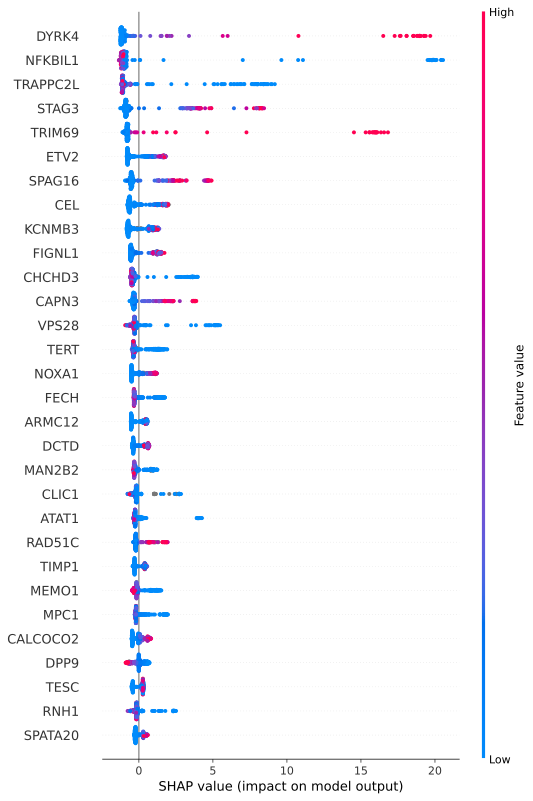

In [61]:
summary_stage_two_untuned_plot_path = locations.output.dir / "plots" / "stage_two_untuned_summary_lifespan.svg"
summary_stage_two_untuned = result_untuned.plot(max_display=30, plot_size=0.4, save = summary_stage_two_untuned_plot_path)
summary_stage_two_untuned

### Comparing metrics ###

In [52]:
stage_one["lifespan"].metrics_average

Metrics(R2=0.8987366217391914, MAE=4.564839706421651, MSE=72.67304359443301, huber=3.7623283132466825)

In [53]:
stage_one["lifespan"].symbols_repeated(6).values

array(['DYRK4', 'NFKBIL1', 'STAG3', 'TRIM69', 'ETV2', 'TRAPPC2L',
       'KCNMB3', 'FIGNL1', 'ARMC12', 'CEL', 'NOXA1', 'CHCHD3', 'TERT',
       'DCTD', 'SPAG16'], dtype=object)

In [54]:
stage_one["lifespan"].symbols_repeated(2).index

Index(['ENSG00000010219', 'ENSG00000204498', 'ENSG00000066923',
       'ENSG00000185880', 'ENSG00000105672', 'ENSG00000167515',
       'ENSG00000171121', 'ENSG00000132436', 'ENSG00000157343',
       'ENSG00000170835', 'ENSG00000188747', 'ENSG00000106554',
       'ENSG00000164362', 'ENSG00000129187', 'ENSG00000144451',
       'ENSG00000172531', 'ENSG00000013288', 'ENSG00000160948',
       'ENSG00000023191', 'ENSG00000165555', 'ENSG00000108384',
       'ENSG00000142002', 'ENSG00000152705', 'ENSG00000132464',
       'ENSG00000066926', 'ENSG00000136436', 'ENSG00000184983',
       'ENSG00000165501', 'ENSG00000164879', 'ENSG00000182612',
       'ENSG00000137343', 'ENSG00000142541', 'ENSG00000213719',
       'ENSG00000102265', 'ENSG00000108786', 'ENSG00000140398'],
      dtype='object')

In [55]:
stage_one["lifespan"].validation_metrics.mean(axis=0)

R^2      0.916
MAE      3.534
MSE     53.920
huber      nan
dtype: float64

In [56]:
(stage_one["lifespan"].symbols_repeated(2).shape, result_untuned.symbols_repeated(2).shape)

((36,), (138,))

In [57]:
result_untuned.metrics_average

Metrics(R2=0.931033739955317, MAE=3.8043610582703975, MSE=49.13212705189508, huber=3.080158806641395)

In [58]:
result_untuned.validation_metrics["R^2"].mean()

0.9415458708261364